# Personal Information
Name: **Mara Smeets**

StudentID: **14629747**

Email: [**mara.smeets@student.uva.nl**](youremail@student.uva.nl)

Submitted on: **22.03.2023**

GitHub link

https://github.com/Mara4444/MSc_Thesis

#### Import relevant packages

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
import nltk
from nltk.tokenize import sent_tokenize
import re
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap
import colorcet as cc

nltk.download('punkt')

%matplotlib inline

c:\Users\maras\anaconda3\envs\eda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maras\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Contents

1. Data context
2. The reasoning tasks
3. Machine translation
4. Language features

# 1. Data Context

In this research, several typical reasoning benchmarks are used: for arithmetic reasoning MGSM (Shi et al., 2022) and MSVAMP (Chen et al., 2023), and for commonsense reasoning XCOPA (Ponti et al., 2020). If time allows, experiments on symbolic reasoning with Coin Flip (Wei et al., 2022) and other logical reasoning with Shuffled Objects (Srivastava et al., 2022) are included.

The MGSM, MSVAMP and XCOPA benchmarks are loaded via huggingface. The Coin Flip and Shuffled Objects datasets are retrieved from Kojima et al. (2022) and loaded from csv.

#### Data loading

In [2]:
def get_dataset_df(name,lang):
    """
    Loads a test dataset from huggingface in the requested language.
    
    Parameters:
    name: name of the dataset ['mgsm', 'xcopa', 'xstorycloze', 'mkqa', 'pawsx', 'xnli' or 'xlsum']
    lang: language of the dataset to load.
    
    Returns:
    Dataset in the specified language as dataframe.
    """
    
    if name == "mgsm":

        dataset = load_dataset("juletxara/mgsm",lang) 
        
        df = pd.DataFrame(data={'question' : dataset["test"]["question"],
                                'answer_number' : dataset["test"]["answer_number"]
                                })
        
        return df
    
    elif name == "xcopa" and lang == "en":

        dataset = load_dataset("pkavumba/balanced-copa")

        df = pd.DataFrame(data={'premise' : dataset["test"]["premise"],
                                'choice1' : dataset["test"]["choice1"],
                                'choice2' : dataset["test"]["choice2"],
                                'question' : dataset["test"]["question"],
                                'label' : dataset["test"]["label"]
                                })
        
        return df

    elif name == "xcopa":

        dataset = load_dataset("xcopa",lang) 
    
        df = pd.DataFrame(data={'premise' : dataset["test"]["premise"],
                                'choice1' : dataset["test"]["choice1"],
                                'choice2' : dataset["test"]["choice2"],
                                'question' : dataset["test"]["question"],
                                'label' : dataset["test"]["label"]
                                })
        
        return df

    elif name == "msvamp":

        dataset = load_dataset("Mathoctopus/MSVAMP",lang)

        df = pd.DataFrame(data={'m_query' : dataset["test"]["m_query"],
                                'response' : dataset["test"]["response"]
                                })
        
        return df
    
    elif name == "coinflip":
        
        dataset = pd.read_csv('../datasets/coinflip/coinflip_' + lang + '.csv', sep=';')
        
        return dataset 

    elif name == "shuffled_objects":

        dataset = pd.read_csv('../datasets/shuffled_objects/shuffled_objects_' + lang + '.csv', sep=';')
        
        return dataset
    
    else:
        print("Dataset name is not correctly specified. Please input 'mgsm', 'msvamp', 'xcopa', 'coinflip' or 'shuffled_objects'.")

In [3]:
mgsm = get_dataset_df("mgsm","en")        
xcopa = get_dataset_df("xcopa",'en') 
msvamp = get_dataset_df('msvamp','en')
coinflip = get_dataset_df('coinflip','eng_Latn')
shuffled_objects = get_dataset_df('shuffled_objects','eng_Latn')

### MGSM

The multilingual arithmetic reasoning ability of LLMs is commonly tested on the MGSM benchmark. It is a multilingual grade-school math problem dataset that consists of the first 250 examples from the GSM8K official test example list (Cobbe et al., 2021). Each problem requires two to eight steps to solve according to the official solution and the answer for each question is a integer value (Shi et al., 2022). The 250 English math problems are human-translated into a typologically diverse set of 10 languages: Bengali, Chinese, French, German, Japanese, Russian, Spanish, Swahili, Telugu, and Thai. 

The dataset consists of the following columns:

question - The arithmetic question (str)

answer_number - The numeric answer (int)



In [4]:
mgsm.head()

question  answer_number
0  Janet’s ducks lay 16 eggs per day. She eats th...             18
1  A robe takes 2 bolts of blue fiber and half th...              3
2  Josh decides to try flipping a house.  He buys...          70000
3  James decides to run 3 sprints 3 times a week....            540
4  Every day, Wendi feeds each of her chickens th...             20

### MSVAMP 

Another benchmark that is commonly used to test the arithmetic reasoning abilities of LLMs is the MSVAMP benchmark. This benchmark is based on the English SVAMP (Patel et al., 2021). Each problem requires one or two arithmetic operations (+, −, ∗, /) in order to solve the question and obtain an integer answer. The 1000 English math problems are machine-translated into the same languages as in the MGSM benchmark, leaving out Telugu. Afterwards, the translations are refined by manual calibration. 

The dataset consists of the following columns:

m_query - The arithmetic question (str)

response - The numeric answer (str)

In [5]:
msvamp.head()

m_query response
0  julia played tag with 18 kids on monday . she ...      8.0
1  julia played tag with 11 kids on monday . she ...      1.0
2  julia played tag with 5 kids on monday . she p...     10.0
3  julia played tag with some kids on monday . sh...      2.0
4  julia played tag with 16 kids on monday . if s...      4.0

### XCOPA

The XCOPA benchmark is commonly used for testing commonsense reasoning performance of LLMs. It is a multilingual multiple–choice classification task database. It contains premises followed by two choices. The model is asked to choose which one is the result or cause of the premise. The XCOPA benchmark contains 500 human-translated premises from the English COPA benchmark (Roemmele et al., 2021). It covers 11 languages from 11 diverse families: Estonian, Haitian Creole, Indonesian, Italian, Quechua, Swahili, Tamil, Thai, Turkish, Vietnamese, and Chinese. The original English COPA dataset is also included.

The dataset consists of the following columns:

premise - The premise (str)

choice1 - The first answer option (str)

choice2 - The second answer option (str)

question - cause or effect (str)

label - binary answer (0: choice1, 1: choice2)

In [6]:
xcopa.head()

premise  \
0  The item was packaged in bubble wrap.   
1                  I emptied my pockets.   
2            Termites invaded the house.   
3      The travelers reached the border.   
4                 The office was closed.   

                                     choice1  \
0                            It was fragile.   
1                 I retrieved a ticket stub.   
2   The termites disappeared from the house.   
3  The patrol agent checked their passports.   
4                          It was a holiday.   

                                           choice2 question  label  
0                                    It was small.    cause      0  
1                                I found a weapon.   effect      0  
2  The termites ate through the wood in the house.   effect      1  
3      The patrol agent accused them of smuggling.   effect      0  
4                                   It was summer.    cause      0

### Coin Flip 

In this symbolic reasoning dataset the model is asked to answer whether a coin is still heads up after people either flip or do not flip the coin. Kojima et al. (2022) created a subset of 500 questions of the original dataset consisting of samples with 4 times flip or not flip trials. This subset is used for the experiments. 

The dataset consists of the following columns:

question - The reasoning question (str)

answer - The correct yes/no answer (str)

answer_ab - The correct answer in multiple choice format (A: yes, B: No) (str)

In [7]:
coinflip.head()

question answer answer_ab
0  A coin is heads up. Whitney flips the coin. Er...    yes         A
1  A coin is heads up. Lucky does not flip the co...     no         B
2  A coin is heads up. Caleb flips the coin. Chas...     no         B
3  A coin is heads up. Silvia flips the coin. Car...     no         B
4  A coin is heads up. Breanna flips the coin. Tr...    yes         A

### Shuffled Objects 

The Tracking Shuffled Objects dataset is used to test the LLMs abilities on other logical reasoning tasks. The original dataset was created by as part of the BIG-bench effort. Tracking Shuffled Objects tests a model’s ability to infer the final state of objects given its initial state and a sequence of object shuffling. Kojima et al. (2022) created a subset of 750 questions where three objects are shuffled. This dataset is used in the experiments.

The dataset consists of the following columns:

input - The reasoning question (str)

A - Answer option A (str)

B - Answer option B (str)

C - Answer option C (str)

answer - The correct answer (str)

answer_ab - The correct answer in multiple choice format (str)

In [8]:
shuffled_objects.head()

input            A           B  \
0  Alice, Bob, and Claire are playing a game. At ...  orange ball  white ball   
1  Alice, Bob, and Claire are playing a game. At ...  orange ball  white ball   
2  Alice, Bob, and Claire are playing a game. At ...  orange ball  white ball   
3  Alice, Bob, and Claire are playing a game. At ...    blue ball  black ball   
4  Alice, Bob, and Claire are playing a game. At ...    blue ball  black ball   

            C       answer answer_abc  
0   blue ball    blue ball          C  
1   blue ball   white ball          B  
2   blue ball  orange ball          A  
3  brown ball    blue ball          A  
4  brown ball   brown ball          C

# 2. The reasoning tasks

Basic question characteristics of the textual data is analyzed: length (# characters), wordcount and # sentences. For each characteristic, the results are visualized using a histogram, boxplot and QQ-plot.

### MGSM

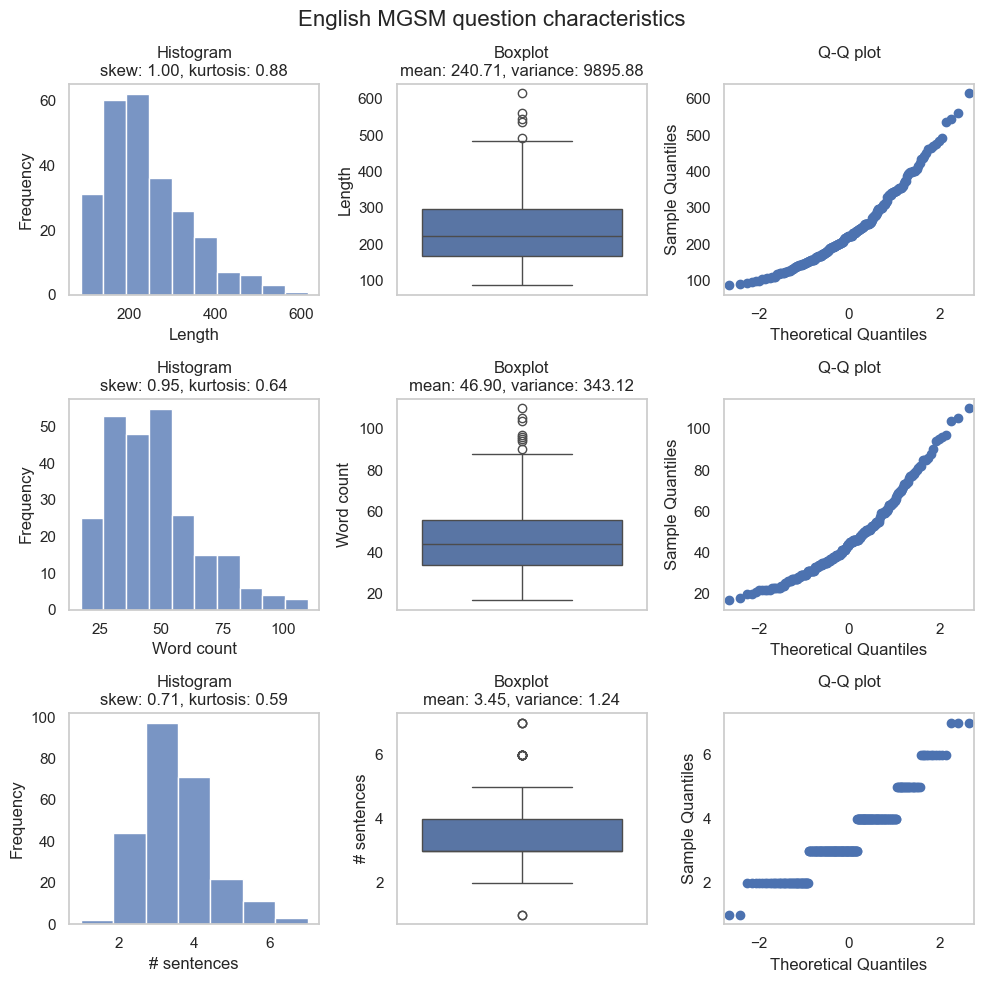

In [9]:
################## Data manipulation #####################
df = pd.DataFrame()

### Questions
length = []
wordcount = []
sentencecount = []  
    
for question in mgsm["question"]:
    length.append(len(question))
    wordcount.append(len(question.strip().split(" ")))
    sentences = sent_tokenize(question)
    sentencecount.append(len(sentences))

df['Length'] = length
df['Wordcount'] = wordcount
df['Nr_sentences'] = sentencecount

################### Plotting #####################

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

### Question length

    # Histogram
sns.histplot(df['Length'], kde=False, bins=10, ax=axes[0,0])
axes[0,0].set_title(f'Histogram\nskew: {df['Length'].skew():.2f}, kurtosis: {df['Length'].kurtosis():.2f}')
axes[0,0].set_xlabel('Length')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(False)

    # Boxplot
sns.boxplot(df['Length'], ax=axes[0,1])
axes[0,1].set_title(f'Boxplot\nmean: {df['Length'].mean():.2f}, variance: {df['Length'].var():.2f}')
axes[0,1].set_ylabel('Length')
axes[0,1].grid(False)

    # QQ plot
sm.qqplot(df['Length'],ax=axes[0,2])
axes[0,2].set_title('Q-Q plot\n')
axes[0,2].grid(False)

### Question wordcount

    # Histogram
sns.histplot(df['Wordcount'], kde=False, bins=10, ax=axes[1,0])
axes[1,0].set_title(f'Histogram\nskew: {df['Wordcount'].skew():.2f}, kurtosis: {df['Wordcount'].kurtosis():.2f}')
axes[1,0].set_xlabel('Word count')
axes[1,0].set_ylabel('Frequency')
axes[1,0].grid(False)

    # Boxplot
sns.boxplot(df['Wordcount'], ax=axes[1,1])
axes[1,1].set_title(f'Boxplot\nmean: {df['Wordcount'].mean():.2f}, variance: {df['Wordcount'].var():.2f}')
axes[1,1].set_ylabel('Word count')
axes[1,1].grid(False)

    # QQ plot
sm.qqplot(df['Wordcount'],ax=axes[1,2])
axes[1,2].set_title('Q-Q plot\n')
axes[1,2].grid(False)

### Question nr sentences

    # Histogram
sns.histplot(df['Nr_sentences'], kde=False, bins=7, ax=axes[2,0])
axes[2,0].set_title(f'Histogram\nskew: {df['Nr_sentences'].skew():.2f}, kurtosis: {df['Nr_sentences'].kurtosis():.2f}')
axes[2,0].set_xlabel('# sentences')
axes[2,0].set_ylabel('Frequency')
axes[2,0].grid(False)

    # Boxplot
sns.boxplot(df['Nr_sentences'], ax=axes[2,1])
axes[2,1].set_title(f'Boxplot\nmean: {df['Nr_sentences'].mean():.2f}, variance: {df['Nr_sentences'].var():.2f}')
axes[2,1].set_ylabel('# sentences')
axes[2,1].grid(False)

    # QQ plot
sm.qqplot(df['Nr_sentences'],ax=axes[2,2])
axes[2,2].set_title('Q-Q plot\n')
axes[2,2].grid(False)

fig.suptitle('English MGSM question characteristics', fontsize=16)
plt.tight_layout()
plt.show()

For the answers specifically we count the number of mathematical operators (i.e. +, -, /, *). The original answers are retrieved from the English GSM8K dataset.

In [10]:
# load dataset
gsm8k = load_dataset('gsm8k','main')

questions = gsm8k['test']['question']
answers = gsm8k['test']['answer']

# extract first 250 questions (which are in the MGSM dataset)
gsm8k = pd.DataFrame(data = {'question' : questions[:250],
                             'answer' : answers[:250]})
gsm8k.head()

question  \
0  Janet’s ducks lay 16 eggs per day. She eats th...   
1  A robe takes 2 bolts of blue fiber and half th...   
2  Josh decides to try flipping a house.  He buys...   
3  James decides to run 3 sprints 3 times a week....   
4  Every day, Wendi feeds each of her chickens th...   

                                              answer  
0  Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...  
1  It takes 2/2=<<2/2=1>>1 bolt of white fiber\nS...  
2  The cost of the house and repairs came out to ...  
3  He sprints 3*3=<<3*3=9>>9 times\nSo he runs 9*...  
4  If each chicken eats 3 cups of feed per day, t...

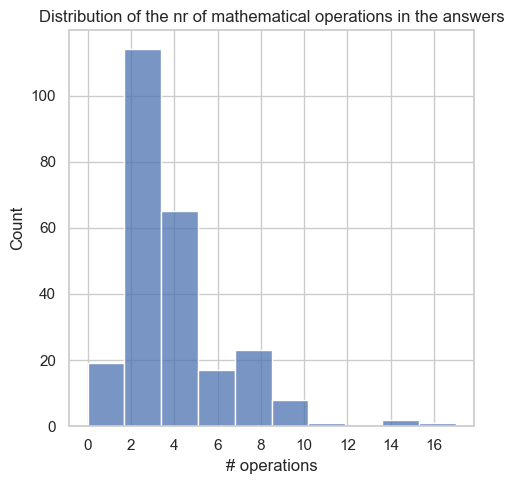

In [11]:
# count number of mathematical operations
plus_countlist = []
min_countlist = []
div_countlist = []
mult_countlist = []

for answer in gsm8k['answer']:
    # first remove the operation parts between << >> 
    pattern = r'<<.*?>>'
    answer = re.sub(pattern, '', answer)
    
    # then count the number of math operations in each answer
    plus_count = 0
    min_count = 0
    div_count = 0
    mult_count = 0
    for i in answer:
        if i == '+':
            plus_count += 1
        elif i == '-':
            min_count += 1
        elif i == '/':
            div_count +=1
        elif i == '*':
            mult_count += 1
    plus_countlist.append(plus_count)
    min_countlist.append(min_count)
    div_countlist.append(div_count)
    mult_countlist.append(mult_count)

gsm8k['Plus'] = plus_countlist
gsm8k['Min'] = min_countlist
gsm8k['Divisions'] = div_countlist
gsm8k['Multiplications'] = mult_countlist
gsm8k['Nr_operations'] = gsm8k[['Plus', 'Min', 'Divisions','Multiplications']].sum(axis=1)

plt.figure(figsize=(5, 5))
sns.histplot(gsm8k['Nr_operations'], kde=False, bins=10)
plt.title('Distribution of the nr of mathematical operations in the answers')
plt.xlabel('# operations')
plt.xticks(np.arange(0,18,2))
    
plt.tight_layout()
plt.show()

### MSVAMP

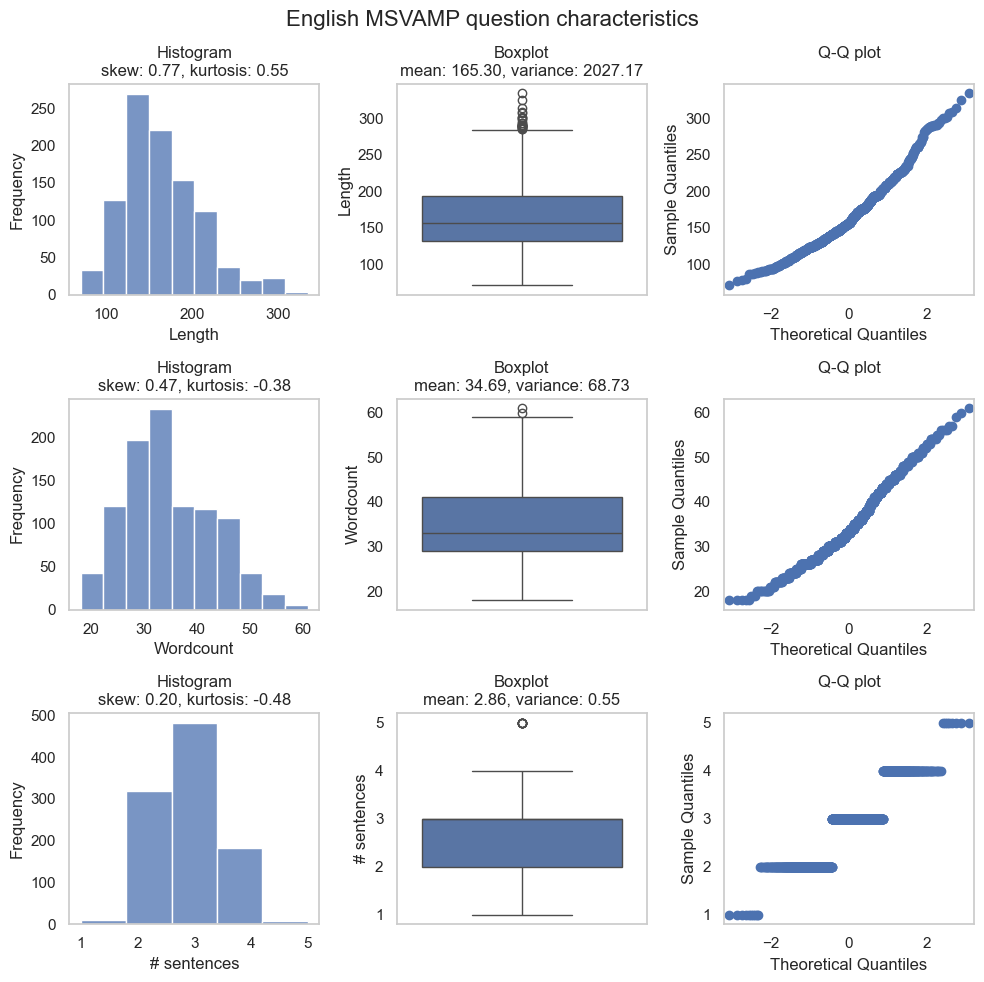

In [12]:
################## Data manipulation #####################
df = pd.DataFrame()

### Questions
length = []
wordcount = []
sentencecount = []  
    
for question in msvamp["m_query"]:
    length.append(len(question))
    wordcount.append(len(question.strip().split(" ")))
    sentences = sent_tokenize(question)
    sentencecount.append(len(sentences))

df['Length'] = length
df['Wordcount'] = wordcount
df['Nr_sentences'] = sentencecount

################### Plotting #####################

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

### Question length

    # Histogram
sns.histplot(df['Length'], kde=False, bins=10, ax=axes[0,0])
axes[0,0].set_title(f'Histogram\nskew: {df['Length'].skew():.2f}, kurtosis: {df['Length'].kurtosis():.2f}')
axes[0,0].set_xlabel('Length')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(False)

    # Boxplot
sns.boxplot(df['Length'], ax=axes[0,1])
axes[0,1].set_title(f'Boxplot\nmean: {df['Length'].mean():.2f}, variance: {df['Length'].var():.2f}')
axes[0,1].set_ylabel('Length')
axes[0,1].grid(False)

    # QQ plot
sm.qqplot(df['Length'],ax=axes[0,2])
axes[0,2].set_title('Q-Q plot\n')
axes[0,2].grid(False)

### Question wordcount

    # Histogram
sns.histplot(df['Wordcount'], kde=False, bins=10, ax=axes[1,0])
axes[1,0].set_title(f'Histogram\nskew: {df['Wordcount'].skew():.2f}, kurtosis: {df['Wordcount'].kurtosis():.2f}')
axes[1,0].set_xlabel('Wordcount')
axes[1,0].set_ylabel('Frequency')
axes[1,0].grid(False)

    # Boxplot
sns.boxplot(df['Wordcount'], ax=axes[1,1])
axes[1,1].set_title(f'Boxplot\nmean: {df['Wordcount'].mean():.2f}, variance: {df['Wordcount'].var():.2f}')
axes[1,1].set_ylabel('Wordcount')
axes[1,1].grid(False)

    # QQ plot
sm.qqplot(df['Wordcount'],ax=axes[1,2])
axes[1,2].set_title('Q-Q plot\n')
axes[1,2].grid(False)

### Question nr sentences

    # Histogram
sns.histplot(df['Nr_sentences'], kde=False, bins=5, ax=axes[2,0])
axes[2,0].set_title(f'Histogram\nskew: {df['Nr_sentences'].skew():.2f}, kurtosis: {df['Nr_sentences'].kurtosis():.2f}')
axes[2,0].set_xlabel('# sentences')
axes[2,0].set_ylabel('Frequency')
axes[2,0].grid(False)

    # Boxplot
sns.boxplot(df['Nr_sentences'], ax=axes[2,1])
axes[2,1].set_title(f'Boxplot\nmean: {df['Nr_sentences'].mean():.2f}, variance: {df['Nr_sentences'].var():.2f}')
axes[2,1].set_ylabel('# sentences')
axes[2,1].grid(False)

    # QQ plot
sm.qqplot(df['Nr_sentences'],ax=axes[2,2])
axes[2,2].set_title('Q-Q plot\n')
axes[2,2].grid(False)

fig.suptitle('English MSVAMP question characteristics', fontsize=16)
plt.tight_layout()
plt.show()

In order to calculate the number of operations in the original MSVAMP answers, the dataset is seperately loaded via huggingface.

In [13]:
msvamp_answers = load_dataset("Mathoctopus/MSVAMP","en")
msvamp_answers = msvamp_answers['test']['equation']
msvamp_answers[:10]

['- number0 number1',
 '- number1 number0',
 '- number1 number0',
 '- number1 number0',
 '- number0 number1',
 '+ number0 number1',
 '+ + number0 number1 number2',
 '+ number0 number1',
 '+ number0 number2',
 '+ number1 number2']

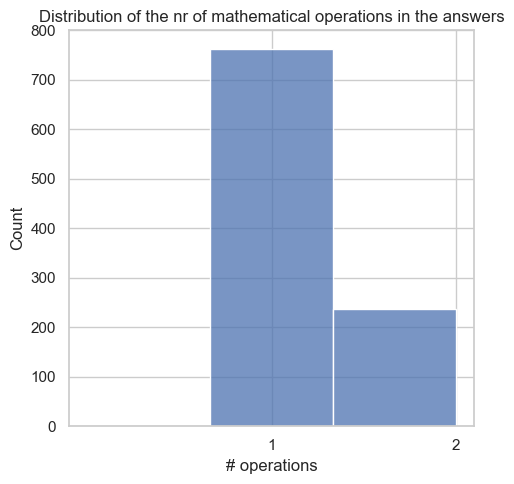

In [15]:
# count number of mathematical operations
nr_operations = []

for answer in msvamp_answers:
    # count the number of math operations in each answer
    plus_count = 0
    min_count = 0
    div_count = 0
    mult_count = 0
    for i in answer:
        if i == '+':
            plus_count += 1
        elif i == '-':
            min_count += 1
        elif i == '/':
            div_count +=1
        elif i == '*':
            mult_count += 1
    nr_operations.append(plus_count+min_count+div_count+mult_count)

plt.figure(figsize=(5, 5))
sns.histplot(nr_operations, kde=False, bins=3)
plt.title('Distribution of the nr of mathematical operations in the answers')
plt.xlabel('# operations')
plt.xticks(np.arange(1,3,1))
    
plt.tight_layout()
plt.show()

### XCOPA

It should be noted that all premises and answer choices are one sentence exactly, so the # sentences characteristic is not included here.

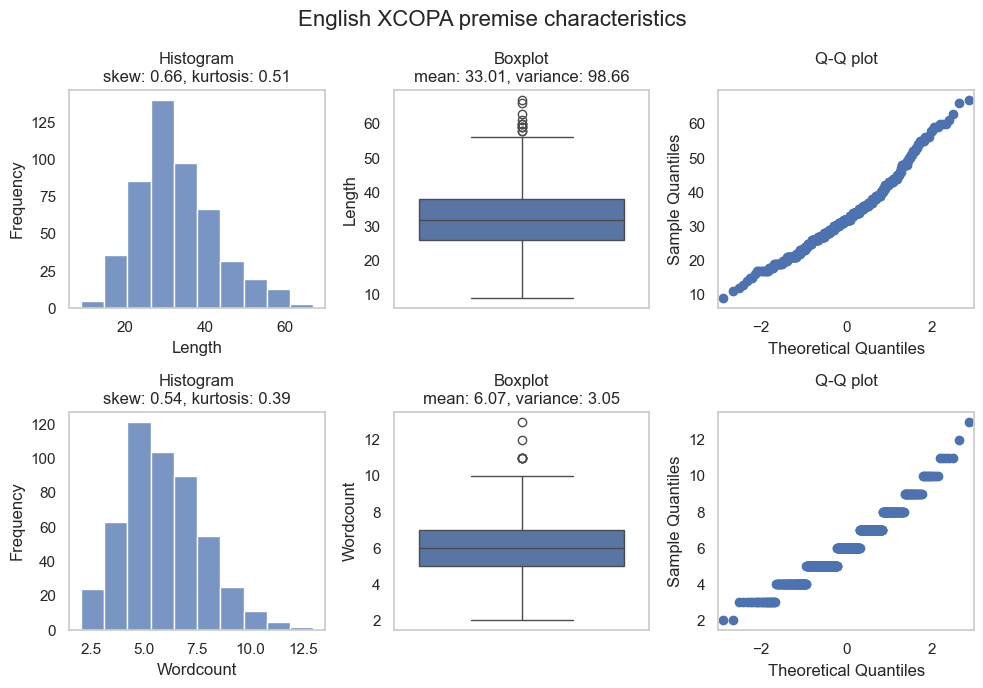

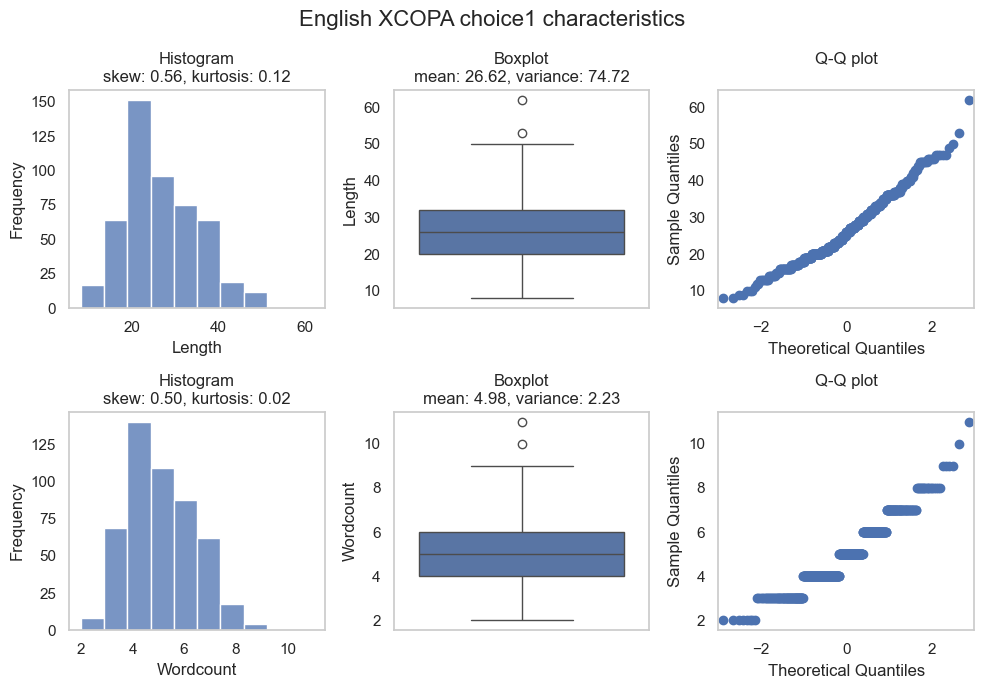

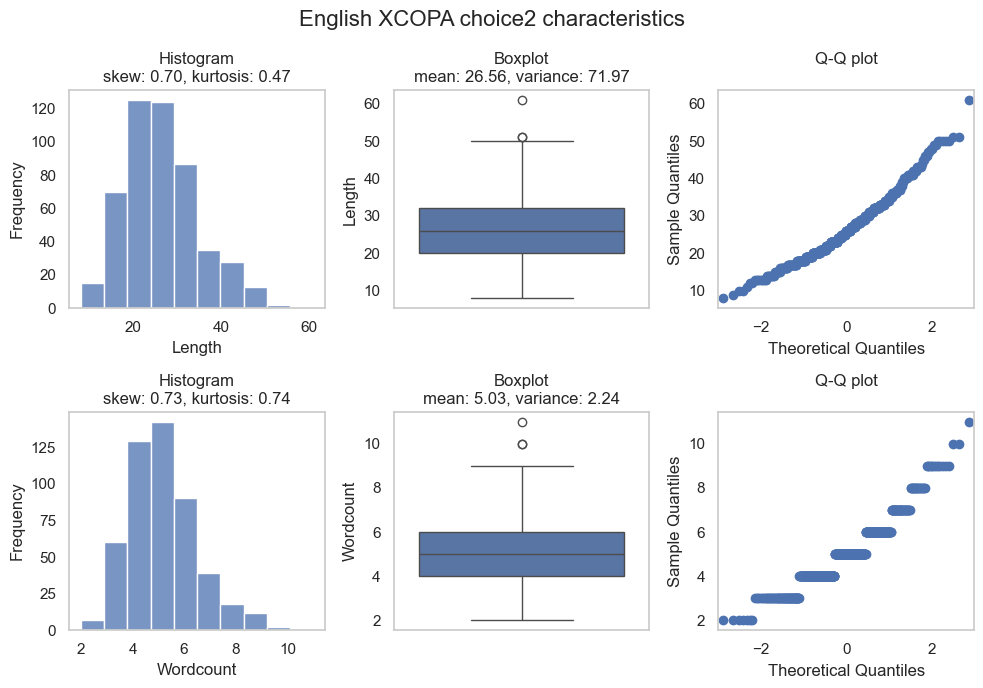

In [16]:
################## Data manipulation #####################
df = pd.DataFrame()

### Questions
length = []
wordcount = []
sentencecount = []  
    
for question in xcopa["premise"]:
    length.append(len(question))
    wordcount.append(len(question.strip().split(" ")))
    sentences = sent_tokenize(question)
    sentencecount.append(len(sentences))

df['Length'] = length
df['Wordcount'] = wordcount
df['Nr_sentences'] = sentencecount

################### Plotting #####################

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

### Question length

    # Histogram
sns.histplot(df['Length'], kde=False, bins=10, ax=axes[0,0])
axes[0,0].set_title(f'Histogram\nskew: {df['Length'].skew():.2f}, kurtosis: {df['Length'].kurtosis():.2f}')
axes[0,0].set_xlabel('Length')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(False)

    # Boxplot
sns.boxplot(df['Length'], ax=axes[0,1])
axes[0,1].set_title(f'Boxplot\nmean: {df['Length'].mean():.2f}, variance: {df['Length'].var():.2f}')
axes[0,1].set_ylabel('Length')
axes[0,1].grid(False)

    # QQ plot
sm.qqplot(df['Length'],ax=axes[0,2])
axes[0,2].set_title('Q-Q plot\n')
axes[0,2].grid(False)

### Question wordcount

    # Histogram
sns.histplot(df['Wordcount'], kde=False, bins=10, ax=axes[1,0])
axes[1,0].set_title(f'Histogram\nskew: {df['Wordcount'].skew():.2f}, kurtosis: {df['Wordcount'].kurtosis():.2f}')
axes[1,0].set_xlabel('Wordcount')
axes[1,0].set_ylabel('Frequency')
axes[1,0].grid(False)

    # Boxplot
sns.boxplot(df['Wordcount'], ax=axes[1,1])
axes[1,1].set_title(f'Boxplot\nmean: {df['Wordcount'].mean():.2f}, variance: {df['Wordcount'].var():.2f}')
axes[1,1].set_ylabel('Wordcount')
axes[1,1].grid(False)

    # QQ plot
sm.qqplot(df['Wordcount'],ax=axes[1,2])
axes[1,2].set_title('Q-Q plot\n')
axes[1,2].grid(False)

fig.suptitle('English XCOPA premise characteristics', fontsize=16)
plt.tight_layout()
plt.show()

################## Data manipulation #####################
df = pd.DataFrame()

### Questions
length = []
wordcount = []
sentencecount = []  
    
for question in xcopa["choice1"]:
    length.append(len(question))
    wordcount.append(len(question.strip().split(" ")))
    sentences = sent_tokenize(question)
    sentencecount.append(len(sentences))

df['Length'] = length
df['Wordcount'] = wordcount
df['Nr_sentences'] = sentencecount

################### Plotting #####################

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

### Question length

    # Histogram
sns.histplot(df['Length'], kde=False, bins=10, ax=axes[0,0])
axes[0,0].set_title(f'Histogram\nskew: {df['Length'].skew():.2f}, kurtosis: {df['Length'].kurtosis():.2f}')
axes[0,0].set_xlabel('Length')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(False)

    # Boxplot
sns.boxplot(df['Length'], ax=axes[0,1])
axes[0,1].set_title(f'Boxplot\nmean: {df['Length'].mean():.2f}, variance: {df['Length'].var():.2f}')
axes[0,1].set_ylabel('Length')
axes[0,1].grid(False)

    # QQ plot
sm.qqplot(df['Length'],ax=axes[0,2])
axes[0,2].set_title('Q-Q plot\n')
axes[0,2].grid(False)

### Question wordcount

    # Histogram
sns.histplot(df['Wordcount'], kde=False, bins=10, ax=axes[1,0])
axes[1,0].set_title(f'Histogram\nskew: {df['Wordcount'].skew():.2f}, kurtosis: {df['Wordcount'].kurtosis():.2f}')
axes[1,0].set_xlabel('Wordcount')
axes[1,0].set_ylabel('Frequency')
axes[1,0].grid(False)

    # Boxplot
sns.boxplot(df['Wordcount'], ax=axes[1,1])
axes[1,1].set_title(f'Boxplot\nmean: {df['Wordcount'].mean():.2f}, variance: {df['Wordcount'].var():.2f}')
axes[1,1].set_ylabel('Wordcount')
axes[1,1].grid(False)

    # QQ plot
sm.qqplot(df['Wordcount'],ax=axes[1,2])
axes[1,2].set_title('Q-Q plot\n')
axes[1,2].grid(False)

fig.suptitle('English XCOPA choice1 characteristics', fontsize=16)
plt.tight_layout()
plt.show()


################## Data manipulation #####################
df = pd.DataFrame()

### Questions
length = []
wordcount = []
sentencecount = []  
    
for question in xcopa["choice2"]:
    length.append(len(question))
    wordcount.append(len(question.strip().split(" ")))
    sentences = sent_tokenize(question)
    sentencecount.append(len(sentences))

df['Length'] = length
df['Wordcount'] = wordcount
df['Nr_sentences'] = sentencecount

################### Plotting #####################

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

### Question length

    # Histogram
sns.histplot(df['Length'], kde=False, bins=10, ax=axes[0,0])
axes[0,0].set_title(f'Histogram\nskew: {df['Length'].skew():.2f}, kurtosis: {df['Length'].kurtosis():.2f}')
axes[0,0].set_xlabel('Length')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(False)

    # Boxplot
sns.boxplot(df['Length'], ax=axes[0,1])
axes[0,1].set_title(f'Boxplot\nmean: {df['Length'].mean():.2f}, variance: {df['Length'].var():.2f}')
axes[0,1].set_ylabel('Length')
axes[0,1].grid(False)

    # QQ plot
sm.qqplot(df['Length'],ax=axes[0,2])
axes[0,2].set_title('Q-Q plot\n')
axes[0,2].grid(False)

### Question wordcount

    # Histogram
sns.histplot(df['Wordcount'], kde=False, bins=10, ax=axes[1,0])
axes[1,0].set_title(f'Histogram\nskew: {df['Wordcount'].skew():.2f}, kurtosis: {df['Wordcount'].kurtosis():.2f}')
axes[1,0].set_xlabel('Wordcount')
axes[1,0].set_ylabel('Frequency')
axes[1,0].grid(False)

    # Boxplot
sns.boxplot(df['Wordcount'], ax=axes[1,1])
axes[1,1].set_title(f'Boxplot\nmean: {df['Wordcount'].mean():.2f}, variance: {df['Wordcount'].var():.2f}')
axes[1,1].set_ylabel('Wordcount')
axes[1,1].grid(False)

    # QQ plot
sm.qqplot(df['Wordcount'],ax=axes[1,2])
axes[1,2].set_title('Q-Q plot\n')
axes[1,2].grid(False)

fig.suptitle('English XCOPA choice2 characteristics', fontsize=16)
plt.tight_layout()
plt.show()


### Coin Flip

All questions in the Coin Flip dataset are aligned such that they consist of 7 sentences. Therefore, this question characteristic is not plotted here.

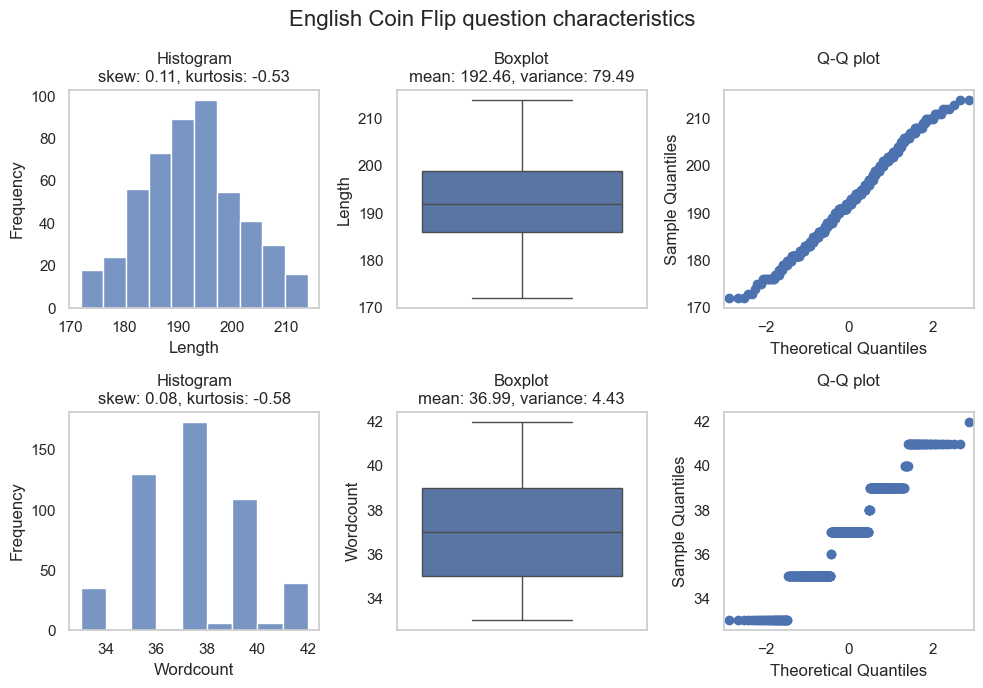

In [17]:
################## Data manipulation #####################
df = pd.DataFrame()

### Questions
length = []
wordcount = []
sentencecount = []  
    
for question in coinflip["question"]:
    length.append(len(question))
    wordcount.append(len(question.strip().split(" ")))
    sentences = sent_tokenize(question)
    sentencecount.append(len(sentences))

df['Length'] = length
df['Wordcount'] = wordcount
df['Nr_sentences'] = sentencecount

################### Plotting #####################

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

### Question length

    # Histogram
sns.histplot(df['Length'], kde=False, bins=10, ax=axes[0,0])
axes[0,0].set_title(f'Histogram\nskew: {df['Length'].skew():.2f}, kurtosis: {df['Length'].kurtosis():.2f}')
axes[0,0].set_xlabel('Length')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(False)

    # Boxplot
sns.boxplot(df['Length'], ax=axes[0,1])
axes[0,1].set_title(f'Boxplot\nmean: {df['Length'].mean():.2f}, variance: {df['Length'].var():.2f}')
axes[0,1].set_ylabel('Length')
axes[0,1].grid(False)

    # QQ plot
sm.qqplot(df['Length'],ax=axes[0,2])
axes[0,2].set_title('Q-Q plot\n')
axes[0,2].grid(False)

### Question wordcount

    # Histogram
sns.histplot(df['Wordcount'], kde=False, bins=9, ax=axes[1,0])
axes[1,0].set_title(f'Histogram\nskew: {df['Wordcount'].skew():.2f}, kurtosis: {df['Wordcount'].kurtosis():.2f}')
axes[1,0].set_xlabel('Wordcount')
axes[1,0].set_ylabel('Frequency')
axes[1,0].grid(False)

    # Boxplot
sns.boxplot(df['Wordcount'], ax=axes[1,1])
axes[1,1].set_title(f'Boxplot\nmean: {df['Wordcount'].mean():.2f}, variance: {df['Wordcount'].var():.2f}')
axes[1,1].set_ylabel('Wordcount')
axes[1,1].grid(False)

    # QQ plot
sm.qqplot(df['Wordcount'],ax=axes[1,2])
axes[1,2].set_title('Q-Q plot\n')
axes[1,2].grid(False)

fig.suptitle('English Coin Flip question characteristics', fontsize=16)
plt.tight_layout()
plt.show()

### Shuffled Objects

Similar to the Coin Flip dataset, all Shuffled Objects questions consist of 7 sentences, thus this characteristic is not plotted here.

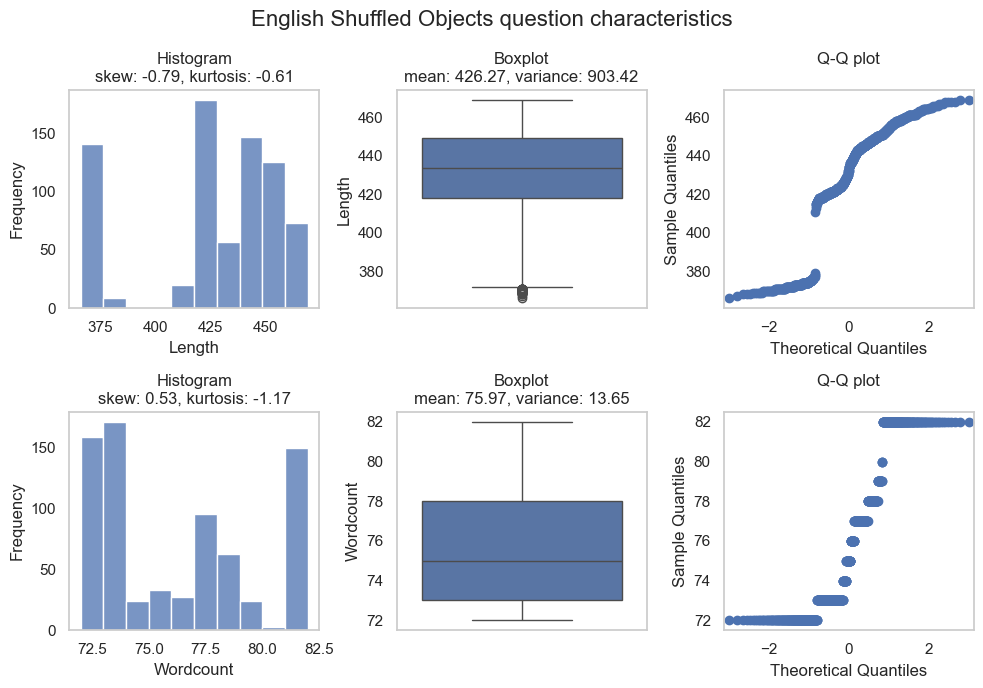

In [18]:
################## Data manipulation #####################
df = pd.DataFrame()

### Questions
length = []
wordcount = []
sentencecount = []  
    
for question in shuffled_objects["input"]:
    length.append(len(question))
    wordcount.append(len(question.strip().split(" ")))
    sentences = sent_tokenize(question)
    sentencecount.append(len(sentences))

df['Length'] = length
df['Wordcount'] = wordcount
df['Nr_sentences'] = sentencecount

################### Plotting #####################

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

### Question length

    # Histogram
sns.histplot(df['Length'], kde=False, bins=10, ax=axes[0,0])
axes[0,0].set_title(f'Histogram\nskew: {df['Length'].skew():.2f}, kurtosis: {df['Length'].kurtosis():.2f}')
axes[0,0].set_xlabel('Length')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(False)

    # Boxplot
sns.boxplot(df['Length'], ax=axes[0,1])
axes[0,1].set_title(f'Boxplot\nmean: {df['Length'].mean():.2f}, variance: {df['Length'].var():.2f}')
axes[0,1].set_ylabel('Length')
axes[0,1].grid(False)

    # QQ plot
sm.qqplot(df['Length'],ax=axes[0,2])
axes[0,2].set_title('Q-Q plot\n')
axes[0,2].grid(False)

### Question wordcount

    # Histogram
sns.histplot(df['Wordcount'], kde=False, bins=10, ax=axes[1,0])
axes[1,0].set_title(f'Histogram\nskew: {df['Wordcount'].skew():.2f}, kurtosis: {df['Wordcount'].kurtosis():.2f}')
axes[1,0].set_xlabel('Wordcount')
axes[1,0].set_ylabel('Frequency')
axes[1,0].grid(False)

    # Boxplot
sns.boxplot(df['Wordcount'], ax=axes[1,1])
axes[1,1].set_title(f'Boxplot\nmean: {df['Wordcount'].mean():.2f}, variance: {df['Wordcount'].var():.2f}')
axes[1,1].set_ylabel('Wordcount')
axes[1,1].grid(False)

    # QQ plot
sm.qqplot(df['Wordcount'],ax=axes[1,2])
axes[1,2].set_title('Q-Q plot\n')
axes[1,2].grid(False)

fig.suptitle('English Shuffled Objects question characteristics', fontsize=16)
plt.tight_layout()
plt.show()

# 3. Language features

The datasets are translated into other languages in order to perform relevant experiments. The NLLB-200-3.3B model is used to perform the machine translations (Costa et al., 2022). As translations from English show the best performance, the English benchmarks are machine translated into the other languages in the targeted list. 

The aim is to experiment on a typologically diverse language set based on language characteristics and have different representations in the pretraining corpus of the LLMs. Another demand for the languages is that they are available in the NLLB-200 model for translation. A set of 59 languages other than English is selected for the experiments. The experimental language set is: Afrikaans, Arabic, Armenian, Balinese, Belarussian, Bengali, Bosnian, Bulgarian, Burmese, Cantonese, Catalan, Chinese, Croatian, Czech, Danish, Dutch, Estonian, Finnish, French, German, Greek, Haitian Creole, Hebrew, Hindi, Hungarian, Indonesian, Italian, Javanese, Japanese, Khmer, Korean, Lao, Maithili, Malay, Malayam, Marathi, Nepali, Norwegian, Polish, Portuguese, Quechuan, Romanian, Russian, Serbian, Slovak, Slovenian, Spanish, Swahili, Swedish, Tagalog, Tamil, Telugu, Thai, Tibetan, Turkish, Ukrainian, Urdu, Vietnamese and Zulu. 

In [2]:
languages = ["afr_Latn","arb_Arab","ban_Latn", "eu_Latn","bel_Cyrl","ben_Beng","bod_Tibt", "bos_Latn","bul_Cyrl", "ces_Latn", "cat_Latn","dan_Latn", "deu_Latn","ell_Grek","est_Latn", 
"fin_Latn", "fra_Latn","hat_Latn", "heb_Hebr","hin_Deva","hun_Latn", "hrv_Latn", "hye_Armn",  "ind_Latn", "ita_Latn","jav_Latn", "jpn_Jpan","khm_Khmr","kor_Hang", 
"lao_Laoo","mai_Deva", "mal_Mlym", "mar_Deva", "mya_Mymr", "nno_Latn", "nld_Latn", "npi_Deva","pol_Latn","por_Latn", "slk_Latn","quy_Latn","ron_Latn", "rus_Cyrl", 
"slv_Latn", "spa_Latn", "srp_Cyrl", "swe_Latn", "swh_Latn", "tam_Taml", "tel_Telu",  "tgl_Latn", 'tha_Thai',"tur_Latn","ukr_Cyrl", "urd_Arab", "vie_Latn" , 'yue_Hant', 
"zho_Hant", "zsm_Latn","zul_Latn"]

print('# languages (excl. English):',len(languages))

# languages (excl. English): 60


The ChrF++ score is used as a metric for machine translation quality. The NLLB language name and language script are retrieved from the FLORES-200 language codes and is merged with the ChrF++ data (Costa et al., 2022). Moreover, the script is extracted from the FLORES-200 code and appended as a new data feature.

In [3]:
# load the languages dataset
nllb_lang = pd.read_csv('nllb_languages.csv', sep=';') 

# load the chrf++ metric dataset
nllb_metrics = pd.read_csv('./nllb_metrics.csv', sep=',')

# extract script data for each language
nllb_lang['Script'] = nllb_lang['FLORES-200 code'].str[-4:]

# select only the metrics where English is the source language
nllb_metrics = nllb_metrics[nllb_metrics['direction'].str[:3] == 'eng']

# add column trg_lang and merge with nllb dataframe
nllb_metrics['trg_lang'] = nllb_metrics['direction'].str[9:]
nllb_lang = pd.merge(nllb_lang,nllb_metrics,left_on='FLORES-200 code', right_on = 'trg_lang')
nllb_lang.drop(columns=['trg_lang'], inplace=True)
nllb_lang.drop(columns=['direction'], inplace=True)

# insert row for English
nllb_lang.loc[len(nllb_lang.index)] = ['English','eng_Latn','Latn',None]

nllb_lang.head()

C:\Users\maras\AppData\Local\Temp\ipykernel_17452\1588755895.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  nllb_lang.loc[len(nllb_lang.index)] = ['English','eng_Latn','Latn',None]


Language FLORES-200 code Script  chrf++
0  Acehnese (Arabic script)        ace_Arab   Arab    19.7
1   Acehnese (Latin script)        ace_Latn   Latn    37.4
2       Mesopotamian Arabic        acm_Arab   Arab    38.4
3      Ta’izzi-Adeni Arabic        acq_Arab   Arab    45.1
4           Tunisian Arabic        aeb_Arab   Arab    34.6

In [7]:
nllb_lang[30:60]

Language FLORES-200 code Script  chrf++
30             Bosnian        bos_Latn   Latn    58.0
31            Buginese        bug_Latn   Latn    33.4
32           Bulgarian        bul_Cyrl   Cyrl    64.3
33             Catalan        cat_Latn   Latn    64.6
34             Cebuano        ceb_Latn   Latn    57.5
35               Czech        ces_Latn   Latn    56.5
36              Chokwe        cjk_Latn   Latn    24.1
37     Central Kurdish        ckb_Arab   Arab    45.2
38       Crimean Tatar        crh_Latn   Latn    44.8
39               Welsh        cym_Latn   Latn    66.2
40              Danish        dan_Latn   Latn    66.6
41              German        deu_Latn   Latn    62.8
42  Southwestern Dinka        dik_Latn   Latn    22.9
43               Dyula        dyu_Latn   Latn    16.2
44            Dzongkha        dzo_Tibt   Tibt    32.6
45               Greek        ell_Grek   Grek    51.3
46           Esperanto        epo_Latn   Latn    60.8
47            Estonian        est_Latn   Latn    54.8
48              Basque        eus_Latn   Latn    48.5
49                 Ewe        ewe_Latn   Latn    38.2
50             Faroese        fao_Latn   Latn    48.0
51              Fijian        fij_Latn   Latn    46.8
52             Finnish        fin_Latn   Latn    53.9
53                 Fon        fon_Latn   Latn    19.3
54              French        fra_Latn   Latn    69.6
55            Friulian        fur_Latn   Latn    57.2
56   Nigerian Fulfulde        fuv_Latn   Latn    23.2
57     Scottish Gaelic        gla_Latn   Latn    48.4
58               Irish        gle_Latn   Latn    54.7
59            Galician        glg_Latn   Latn    59.8

In [4]:
print('Details of the ChrF++ score for English to all available languages in the NLLB-200 model: \nMin, max, mean (%.0f, %.0f, %.0f) ' % (nllb_lang['chrf++'].min(), nllb_lang['chrf++'].max(), nllb_lang['chrf++'].mean()))

Details of the ChrF++ score for English to all available languages in the NLLB-200 model: 
Min, max, mean (11, 70, 45) 


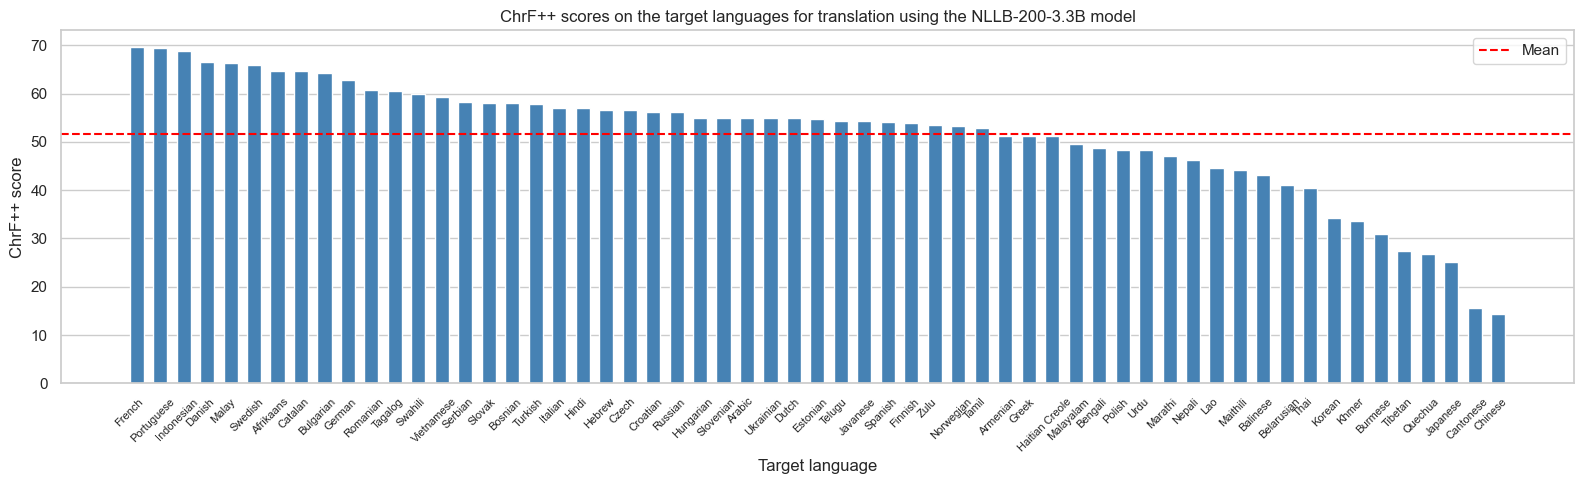

Details of the ChrF++ score for English to all languages in our language set: 
Min, max, mean (14, 70, 52) 


In [5]:
# Language set
nllb_chrf = nllb_lang.loc[nllb_lang['FLORES-200 code'].isin(languages)]

# sort chrf++ values
nllb_chrf_sorted = nllb_chrf.sort_values(by='chrf++', ascending=False)

# drop irrelevant row for English language
nllb_chrf_sorted = nllb_chrf_sorted.drop(nllb_chrf_sorted[nllb_chrf_sorted['Language'] == 'English'].index)

# rename language name
nllb_chrf_sorted.loc[nllb_chrf_sorted['Language'] == "Chinese (Traditional)", 'Language'] = 'Chinese'
nllb_chrf_sorted.loc[nllb_chrf_sorted['Language'] == "Norwegian Nynorsk", 'Language'] = 'Norwegian'
nllb_chrf_sorted.loc[nllb_chrf_sorted['Language'] == "Yue Chinese", 'Language'] = 'Cantonese'
nllb_chrf_sorted.loc[nllb_chrf_sorted['Language'] == "Standard Malay", 'Language'] = 'Malay'
nllb_chrf_sorted.loc[nllb_chrf_sorted['Language'] == "Standard Tibetan", 'Language'] = 'Tibetan'
nllb_chrf_sorted.loc[nllb_chrf_sorted['Language'] == "Modern Standard Arabic", 'Language'] = 'Arabic'
nllb_chrf_sorted.loc[nllb_chrf_sorted['Language'] == "Ayacucho Quechua", 'Language'] = 'Quechua'

# extract mean chrf++ value
mean_chrf = np.mean(nllb_chrf['chrf++'])

plt.figure(figsize=(16, 5))
sns.set_theme(style="whitegrid")
bars = plt.bar(nllb_chrf_sorted['Language'], nllb_chrf_sorted['chrf++'], color='steelblue', width=0.6, align='edge')

# Add a horizontal line for mean
plt.axhline(y=mean_chrf, color='red', linestyle='--', label='Mean')  

labels = [
    "Afrikaans", "Arabic", "Armenian", "Balinese", "Basque", "Belarussian", "Bengali", 
    "Bosnian", "Bulgarian", "Burmese", "Cantonese", "Catalan", "Chinese", 
    "Croatian", "Czech", "Danish", "Dutch", "Estonian", "Finnish", "French", 
    "German", "Greek", "Haitian Creole", "Hebrew", "Hindi", "Hungarian", "Indonesian", "Italian", 
    "Javanese", "Japanese", "Khmer", "Korean", "Lao", "Maithili", "Malay", "Malayam",
    "Marathi", "Nepali", "Norwegian", "Polish", "Portuguese", "Quechua", 
    "Romanian", "Russian", "Serbian", "Slovak", "Slovenian", "Spanish", 
    "Swahili", "Swedish", "Tagalog", "Tamil", "Telugu", "Thai", "Tibetan", 
    "Turkish", "Ukrainian", "Urdu",  "Vietnamese", "Zulu"
]

plt.xlabel('Target language')
plt.ylabel('ChrF++ score')
plt.title('ChrF++ scores on the target languages for translation using the NLLB-200-3.3B model')
plt.xticks(rotation=45, fontsize=8)
plt.grid(False, axis='x')
plt.legend()
plt.tight_layout()  
plt.show()

print('Details of the ChrF++ score for English to all languages in our language set: \nMin, max, mean (%.0f, %.0f, %.0f) ' % (nllb_chrf_sorted['chrf++'].min(), nllb_chrf_sorted['chrf++'].max(), nllb_chrf_sorted['chrf++'].mean()))

### WALS

Lastly, the World Atlas of Language Structures database (WALS) is used as data source for language properties (Dryer et al., 2013). This database consists of structural (e.g. phonological, grammatical and lexical) features of languages. This dataset is initially used to visualize some relevant language properties of the experimental language set for the EDA. If time allows, language similarity metrics are determined and used in the evaluation of the experimental results.

### Data loading

In [8]:
walsdata = pd.read_csv('../datasets/wals/language.csv', sep=',')

#### Data cleaning

First, we select only the languages in the walsdata set that are included in our experiment. As the language codes in the WALS dataset are not equal to the FLORES-200 language codes for all languages, the WALS codes are manually adapted for these languages. The remaining dataset shows 59 languages and 202 columns. It should be noted that the languages Croatian and Serbian are considered as one language 'Serbian-Croation' in the WALS dataset.

In [9]:
languages_wals = ["afr","ams","arm","bal","bsq","blr","ben","tib","bos","bul","ctl","cze","dsh","dut","ger","eng","est","grk","fin","fre","scr","hcr","heb","hin","hun", "ind", "ita","jav","jpn","khm","kor","lao","mai","mym","mhi","mly","brm","nep","nor","pol","por","qay","rus", "spa","svk","swa","swe","rom","slo","tel","tag","tml",'tha',"tur","urd","vie","cnt","mnd","ukr","zul"]

walsdata_test = walsdata.loc[walsdata['wals_code'].isin(languages_wals)]

walsdata_test.shape

(60, 202)

The NLLB data is merged into the WALS dataset. The language names that differ between the datasets are manually changed. Irrelevant or duplicate columns are removed, and the language names are set as index. In total, the dataset remains with 199 features. 

In [10]:
# change merge column name
nllb_lang.rename(columns = {'Language':'Name'}, inplace = True) 

# Change names that differ in the nllb language name and wals language name
nllb_lang.loc[nllb_lang['Name'] == 'Norwegian Nynorsk', 'Name'] = 'Norwegian'
nllb_lang.loc[nllb_lang['Name'] == 'Serbian', 'Name'] = 'Serbian-Croatian'
nllb_lang.loc[nllb_lang['Name'] == 'Slovenian', 'Name'] = 'Slovene'
nllb_lang.loc[nllb_lang['Name'] == 'Chinese (Traditional)', 'Name'] = 'Mandarin'
nllb_lang.loc[nllb_lang['Name'] == 'Standard Malay', 'Name'] = 'Malay'
nllb_lang.loc[nllb_lang['Name'] == 'Modern Standard Arabic', 'Name'] = 'Arabic (Modern Standard)'
nllb_lang.loc[nllb_lang['Name'] == 'Belarusian', 'Name'] = 'Belorussian'
nllb_lang.loc[nllb_lang['Name'] == 'Yue Chinese', 'Name'] = 'Cantonese'
nllb_lang.loc[nllb_lang['Name'] == 'Greek', 'Name'] = 'Greek (Modern)'
nllb_lang.loc[nllb_lang['Name'] == 'Hebrew', 'Name'] = 'Hebrew (Modern)'
nllb_lang.loc[nllb_lang['Name'] == 'Ayacucho Quechua', 'Name'] = 'Quechua (Ayacucho)'
nllb_lang.loc[nllb_lang['Name'] == 'Standard Tibetan', 'Name'] = 'Tibetan (Standard Spoken)'
nllb_lang.loc[nllb_lang['Name'] == 'Armenian', 'Name'] = 'Armenian (Eastern)'


# merge the script values to the WALS dataset based on the language name
walsdata_test = pd.merge(walsdata_test, nllb_lang)

# rename walsdata language names for simplicity
walsdata_test.loc[walsdata_test['Name'] == 'Mandarin', 'Name'] = 'Chinese'
walsdata_test.loc[walsdata_test['Name'] == 'Arabic (Modern Standard)', 'Name'] = 'Arabic'
walsdata_test.loc[walsdata_test['Name'] == 'Greek (Modern)', 'Name'] = 'Greek'
walsdata_test.loc[walsdata_test['Name'] == 'Hebrew (Modern)', 'Name'] = 'Hebrew'
walsdata_test.loc[walsdata_test['Name'] == 'Tibetan (Standard Spoken)', 'Name'] = 'Tibetan'
walsdata_test.loc[walsdata_test['Name'] == 'Quechua (Ayacucho)', 'Name'] = 'Quechua'
walsdata_test.loc[walsdata_test['Name'] == 'Armenian (Eastern)', 'Name'] = 'Armenian'

# set index and drop irrelevant columns
walsdata_test = walsdata_test.set_index(walsdata_test['Name'])
walsdata_test = walsdata_test.drop(columns=['glottocode','Name','iso_code','macroarea','countrycodes','FLORES-200 code'])

walsdata_test.shape

(60, 199)

#### Exploring the data


In [11]:
walsdata_test.head()

wals_code   latitude  longitude            genus         family  \
Name                                                                        
Afrikaans       afr -31.000000      22.00         Germanic  Indo-European   
Arabic          ams  25.000000      42.00          Semitic   Afro-Asiatic   
Armenian        arm  40.000000      45.00         Armenian  Indo-European   
Balinese        bal  -8.333333     115.25  Malayo-Sumbawan   Austronesian   
Bengali         ben  24.000000      90.00            Indic  Indo-European   

          1A Consonant Inventories 2A Vowel Quality Inventories  \
Name                                                              
Afrikaans                      NaN                          NaN   
Arabic                         NaN                          NaN   
Armenian        4 Moderately large              2 Average (5-6)   
Balinese                       NaN                          NaN   
Bengali         4 Moderately large               3 Large (7-14)   

          3A Consonant-Vowel Ratio 4A Voicing in Plosives and Fricatives  \
Name                                                                       
Afrikaans                      NaN                                   NaN   
Arabic                         NaN                                   NaN   
Armenian         4 Moderately high                 3 In fricatives alone   
Balinese                       NaN                                   NaN   
Bengali                  3 Average                   2 In plosives alone   

          5A Voicing and Gaps in Plosive Systems  ...  \
Name                                              ...   
Afrikaans                                    NaN  ...   
Arabic                                       NaN  ...   
Armenian                                 1 Other  ...   
Balinese                                     NaN  ...   
Bengali          2 None missing in /p t k b d g/  ...   

          109B Other Roles of Applied Objects 10B Nasal Vowels in West Africa  \
Name                                                                            
Afrikaans                                 NaN                             NaN   
Arabic                                    NaN                             NaN   
Armenian        5 No applicative construction                             NaN   
Balinese                                  NaN                             NaN   
Bengali                                   NaN                             NaN   

          25B Zero Marking of A and P Arguments  \
Name                                              
Afrikaans                                   NaN   
Arabic                                      NaN   
Armenian                                    NaN   
Balinese                                    NaN   
Bengali                                     NaN   

          21B Exponence of Tense-Aspect-Mood Inflection  \
Name                                                      
Afrikaans                                           NaN   
Arabic                                              NaN   
Armenian                                            NaN   
Balinese                                            NaN   
Bengali                                             NaN   

          108B Productivity of the Antipassive Construction  \
Name                                                          
Afrikaans                                               NaN   
Arabic                                                  NaN   
Armenian                                   4 no antipassive   
Balinese                                                NaN   
Bengali                                                 NaN   

          130B Cultural Categories of Languages with Identity of 'Finger' and 'Hand'  \
Name                                                                                   
Afrikaans                                                NaN                           
Arabic               

The method proposed by Georgi et al. (2010) is used to define a similarity metric based on WALS data. In order to deal with the large amount of missing values, the paper proposes to remove all languages which have less than 25 features values filled. This eliminates many languages that simply do not have enough features to be adequately represented. In addition, features that cover less than 10\% of the selected languages are removed.

Following this method, the following features and language would be excluded from evaluation of language similarity using WALS:

Languages (7): Bosnian, Malay, Quechua, Haitian Creole, Slovak, Balinese and Afrikaans.

Features (26): 10B, 39B, 90 (DEFG), 130B, 139A, 140A, 141A, 143 (BCD), 144 (CFGMNOTUVWXY)

In [27]:
# nr. languages with <25 features filled
languages_above_threshold = walsdata_test.isnull().sum(axis=1) >= len(walsdata_test.columns) - 25

print('Removed languages (<25 features):',languages_above_threshold.sum())

# nr. features with <10% coverage
missing_values2 = walsdata_test.isnull().sum(axis=0)

threshold = len(walsdata_test) - np.ceil(len(walsdata_test)/10)

features_above_threshold = missing_values2[missing_values2 > threshold].index.tolist()

# walsdata_test = walsdata_test.drop(columns=features_above_threshold)

print('Removed features (<10% coverage):',len(features_above_threshold))

Removed languages (<25 features): 7
Removed features (<10% coverage): 26


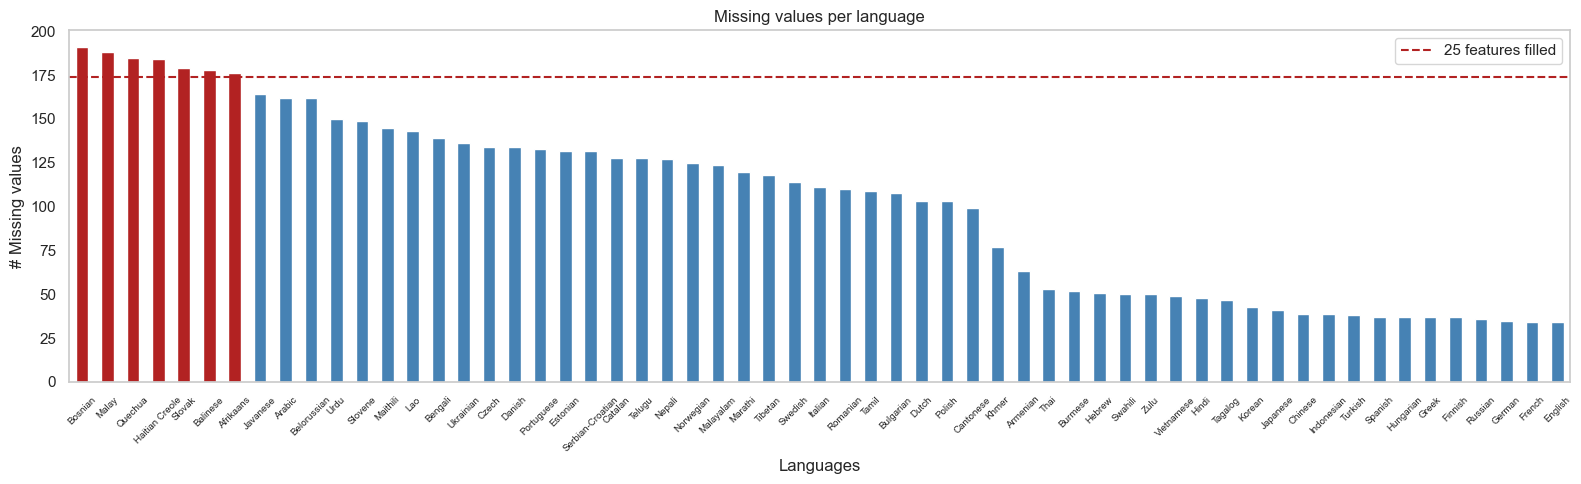

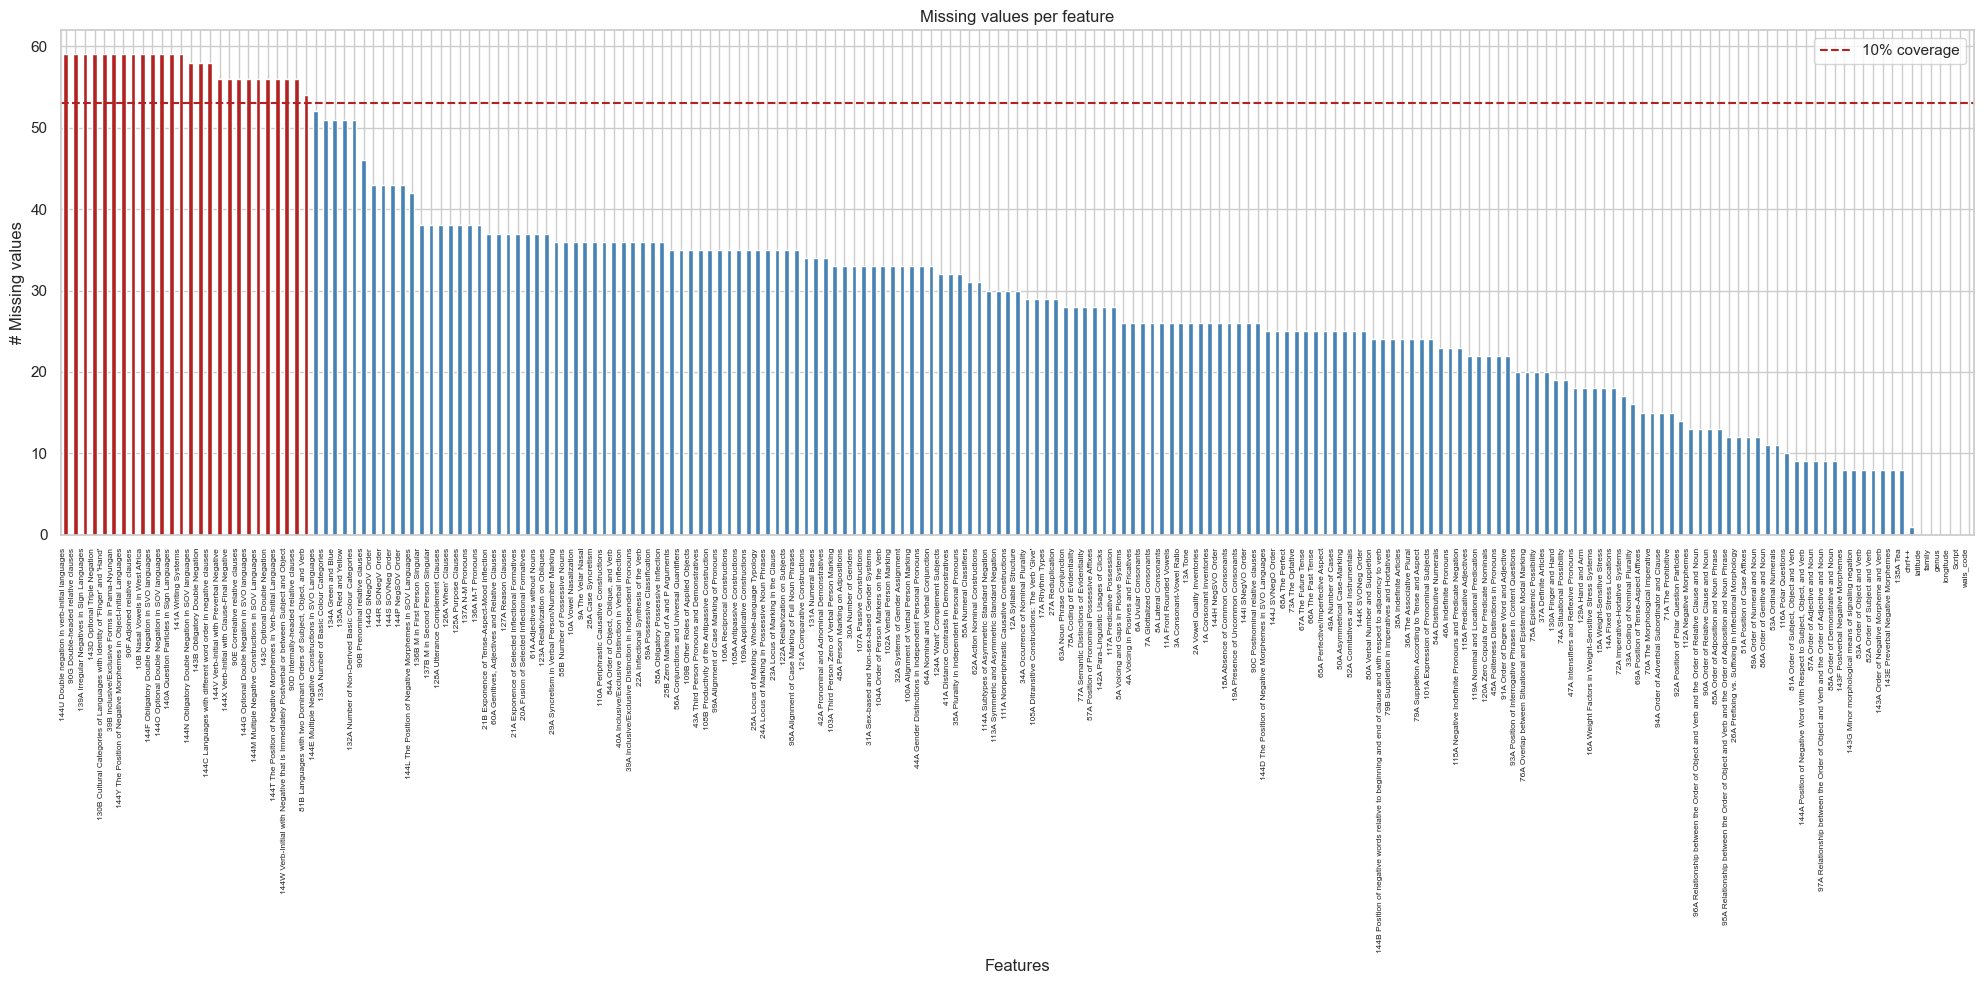

In [28]:
sns.set_theme(style="whitegrid")

# missing value per language
missing_values_lang = walsdata_test.isnull().sum(axis=1)
missing_values_lang = missing_values_lang.sort_values(ascending=False)

threshold = len(walsdata_test.columns) - 25

colors = ['firebrick' if value > threshold else 'steelblue' for value in missing_values_lang]

fig, ax = plt.subplots(figsize=(16, 5))
missing_values_lang.plot(kind='bar', color=colors, ax=ax)

plt.axhline(y=threshold, color='firebrick', linestyle='--', label='25 features filled')  

plt.title("Missing values per language")
plt.ylabel("# Missing values")
plt.xlabel("Languages")
plt.xticks(rotation=45,fontsize=7)
plt.grid(False)

plt.tight_layout()
plt.legend()
plt.show()

# missing value per feature 
missing_values_features = walsdata_test.isnull().sum(axis=0)
missing_values_features = missing_values_features.sort_values(ascending=False)

threshold = len(walsdata_test) - np.ceil(len(walsdata_test)/10)

colors = ['firebrick' if value > threshold else 'steelblue' for value in missing_values_features]

fig, ax = plt.subplots(figsize=(20, 10))
missing_values_features.plot(kind='bar', color=colors, ax=ax)

plt.axhline(y=threshold, color='firebrick', linestyle='--', label='10% coverage')  

xticklabels = [label for label in missing_values_features.index]
ax.set_xticklabels(xticklabels, fontsize=6 ,ha='right')

plt.title("Missing values per feature")
plt.ylabel("# Missing values")
plt.xlabel("Features")

plt.tight_layout()
plt.legend()
plt.show()



The features are grouped per category as indicated in the WALS dataset. The features that have <10% coverage are removed

In [29]:
### feature groups
# genus = ['genus']
# family = ['family']
# script = ['Script']
# geo = ['longitude','latitude']
# phonology = ['1A Consonant Inventories','2A Vowel Quality Inventories','3A Consonant-Vowel Ratio','4A Voicing in Plosives and Fricatives','5A Voicing and Gaps in Plosive Systems','6A Uvular Consonants','7A Glottalized Consonants','8A Lateral Consonants','9A The Velar Nasal','10A Vowel Nasalization','11A Front Rounded Vowels','12A Syllable Structure','13A Tone','14A Fixed Stress Locations','15A Weight-Sensitive Stress','16A Weight Factors in Weight-Sensitive Stress Systems','17A Rhythm Types','18A Absence of Common Consonants','19A Presence of Uncommon Consonants']
# morphology = ['20A Fusion of Selected Inflectional Formatives','21A Exponence of Selected Inflectional Formatives','22A Inflectional Synthesis of the Verb','23A Locus of Marking in the Clause','24A Locus of Marking in Possessive Noun Phrases','25A Locus of Marking: Whole-language Typology','26A Prefixing vs. Suffixing in Inflectional Morphology','27A Reduplication','28A Case Syncretism','29A Syncretism in Verbal Person/Number Marking']
# nominal_cat = ['30A Number of Genders','31A Sex-based and Non-sex-based Gender Systems','32A Systems of Gender Assignment','33A Coding of Nominal Plurality','34A Occurrence of Nominal Plurality','35A Plurality in Independent Personal Pronouns','36A The Associative Plural','37A Definite Articles','38A Indefinite Articles','39A Inclusive/Exclusive Distinction in Independent Pronouns','40A Inclusive/Exclusive Distinction in Verbal Inflection','41A Distance Contrasts in Demonstratives','42A Pronominal and Adnominal Demonstratives','43A Third Person Pronouns and Demonstratives','44A Gender Distinctions in Independent Personal Pronouns','45A Politeness Distinctions in Pronouns','46A Indefinite Pronouns','47A Intensifiers and Reflexive Pronouns','48A Person Marking on Adpositions','49A Number of Cases','50A Asymmetrical Case-Marking','51A Position of Case Affixes','52A Comitatives and Instrumentals','53A Ordinal Numerals','54A Distributive Numerals','55A Numeral Classifiers','56A Conjunctions and Universal Quantifiers','57A Position of Pronominal Possessive Affixes']
# nominal_syn = ['58A Obligatory Possessive Inflection','59A Possessive Classification','60A Genitives, Adjectives and Relative Clauses','61A Adjectives without Nouns','62A Action Nominal Constructions','63A Noun Phrase Conjunction','64A Nominal and Verbal Conjunction']
# verbal_cat = ['65A Perfective/Imperfective Aspect','66A The Past Tense','67A The Future Tense','68A The Perfect','69A Position of Tense-Aspect Affixes','70A The Morphological Imperative','71A The Prohibitive','72A Imperative-Hortative Systems','73A The Optative','74A Situational Possibility','75A Epistemic Possibility','76A Overlap between Situational and Epistemic Modal Marking','77A Semantic Distinctions of Evidentiality','78A Coding of Evidentiality','79A Suppletion According to Tense and Aspect','80A Verbal Number and Suppletion']
# wordorder = ['81A Order of Subject, Object and Verb','82A Order of Subject and Verb','83A Order of Object and Verb','84A Order of Object, Oblique, and Verb','85A Order of Adposition and Noun Phrase','86A Order of Genitive and Noun','87A Order of Adjective and Noun','88A Order of Demonstrative and Noun','89A Order of Numeral and Noun','90A Order of Relative Clause and Noun','91A Order of Degree Word and Adjective','92A Position of Polar Question Particles','93A Position of Interrogative Phrases in Content Questions','94A Order of Adverbial Subordinator and Clause','95A Relationship between the Order of Object and Verb and the Order of Adposition and Noun Phrase','96A Relationship between the Order of Object and Verb and the Order of Relative Clause and Noun','97A Relationship between the Order of Object and Verb and the Order of Adjective and Noun','143A Order of Negative Morpheme and Verb','143B Obligatory Double Negation','143C Optional Double Negation','143D Optional Triple Negation','143E Preverbal Negative Morphemes','143F Postverbal Negative Morphemes','143G Minor morphological means of signaling negation','144A Position of Negative Word With Respect to Subject, Object, and Verb','144B Position of negative words relative to beginning and end of clause and with respect to adjacency to verb','144C Languages with different word order in negative clauses','144D The Position of Negative Morphemes in SVO Languages','144E Multiple Negative Constructions in SVO Languages','144F Obligatory Double Negation in SVO languages','144G Optional Double Negation in SVO languages','144H NegSVO Order','144I SNegVO Order','144J SVNegO Order','144K SVONeg Order','144L The Position of Negative Morphemes in SOV Languages','144M Multiple Negative Constructions in SOV Languages','144N Obligatory Double Negation in SOV languages','144O Optional Double Negation in SOV languages','144P NegSOV Order','144Q SNegOV Order','144R SONegV Order','144S SOVNeg Order','144T The Position of Negative Morphemes in Verb-Initial Languages','144U Double negation in verb-initial languages','144V Verb-Initial with Preverbal Negative','144W Verb-Initial with Negative that is Immediately Postverbal or between Subject and Object','144X Verb-Initial with Clause-Final Negative','144Y The Position of Negative Morphemes in Object-Initial Languages']
# simple_clause = ["100A Alignment of Verbal Person Marking","101A Expression of Pronominal Subjects","102A Verbal Person Marking","103A Third Person Zero of Verbal Person Marking","104A Order of Person Markers on the Verb","105A Ditransitive Constructions: The Verb 'Give'","106A Reciprocal Constructions","107A Passive Constructions","108A Antipassive Constructions","108B Productivity of the Antipassive Construction","109A Applicative Constructions","109B Other Roles of Applied Objects","110A Periphrastic Causative Constructions","111A Nonperiphrastic Causative Constructions","112A Negative Morphemes","113A Symmetric and Asymmetric Standard Negation","114A Subtypes of Asymmetric Standard Negation","115A Negative Indefinite Pronouns and Predicate Negation","116A Polar Questions","117A Predicative Possession","118A Predicative Adjectives","119A Nominal and Locational Predication","120A Zero Copula for Predicate Nominals","121A Comparative Constructions"]
# complex_sentences = ["122A Relativization on Subjects","123A Relativization on Obliques","124A 'Want' Complement Subjects","125A Purpose Clauses","126A 'When' Clauses","127A Reason Clauses","128A Utterance Complement Clauses"]
# lexicon = ['129A Hand and Arm','130A Finger and Hand','131A Numeral Bases','132A Number of Non-Derived Basic Colour Categories','133A Number of Basic Colour Categories','134A Green and Blue','135A Red and Yellow','136A M-T Pronouns','137A N-M Pronouns','138A Tea']
# other = ['141A Writing Systems','142A Para-Linguistic Usages of Clicks']


#### feature groups excluding the removed ones
genus = ['genus']
family = ['family']
script = ['Script']
geo = ['longitude','latitude']
phonology = ['1A Consonant Inventories','2A Vowel Quality Inventories','3A Consonant-Vowel Ratio','4A Voicing in Plosives and Fricatives','5A Voicing and Gaps in Plosive Systems','6A Uvular Consonants','7A Glottalized Consonants','8A Lateral Consonants','9A The Velar Nasal','10A Vowel Nasalization','11A Front Rounded Vowels','12A Syllable Structure','13A Tone','14A Fixed Stress Locations','15A Weight-Sensitive Stress','16A Weight Factors in Weight-Sensitive Stress Systems','17A Rhythm Types','18A Absence of Common Consonants','19A Presence of Uncommon Consonants']
morphology = ['20A Fusion of Selected Inflectional Formatives','21A Exponence of Selected Inflectional Formatives','22A Inflectional Synthesis of the Verb','23A Locus of Marking in the Clause','24A Locus of Marking in Possessive Noun Phrases','25A Locus of Marking: Whole-language Typology','26A Prefixing vs. Suffixing in Inflectional Morphology','27A Reduplication','28A Case Syncretism','29A Syncretism in Verbal Person/Number Marking']
nominal_cat = ['30A Number of Genders','31A Sex-based and Non-sex-based Gender Systems','32A Systems of Gender Assignment','33A Coding of Nominal Plurality','34A Occurrence of Nominal Plurality','35A Plurality in Independent Personal Pronouns','36A The Associative Plural','37A Definite Articles','38A Indefinite Articles','39A Inclusive/Exclusive Distinction in Independent Pronouns','40A Inclusive/Exclusive Distinction in Verbal Inflection','41A Distance Contrasts in Demonstratives','42A Pronominal and Adnominal Demonstratives','43A Third Person Pronouns and Demonstratives','44A Gender Distinctions in Independent Personal Pronouns','45A Politeness Distinctions in Pronouns','46A Indefinite Pronouns','47A Intensifiers and Reflexive Pronouns','48A Person Marking on Adpositions','49A Number of Cases','50A Asymmetrical Case-Marking','51A Position of Case Affixes','52A Comitatives and Instrumentals','53A Ordinal Numerals','54A Distributive Numerals','55A Numeral Classifiers','56A Conjunctions and Universal Quantifiers','57A Position of Pronominal Possessive Affixes']
nominal_syn = ['58A Obligatory Possessive Inflection','59A Possessive Classification','60A Genitives, Adjectives and Relative Clauses','61A Adjectives without Nouns','62A Action Nominal Constructions','63A Noun Phrase Conjunction','64A Nominal and Verbal Conjunction']
verbal_cat = ['65A Perfective/Imperfective Aspect','66A The Past Tense','67A The Future Tense','68A The Perfect','69A Position of Tense-Aspect Affixes','70A The Morphological Imperative','71A The Prohibitive','72A Imperative-Hortative Systems','73A The Optative','74A Situational Possibility','75A Epistemic Possibility','76A Overlap between Situational and Epistemic Modal Marking','77A Semantic Distinctions of Evidentiality','78A Coding of Evidentiality','79A Suppletion According to Tense and Aspect','80A Verbal Number and Suppletion']
wordorder = ['81A Order of Subject, Object and Verb','82A Order of Subject and Verb','83A Order of Object and Verb','84A Order of Object, Oblique, and Verb','85A Order of Adposition and Noun Phrase','86A Order of Genitive and Noun','87A Order of Adjective and Noun','88A Order of Demonstrative and Noun','89A Order of Numeral and Noun','90A Order of Relative Clause and Noun','91A Order of Degree Word and Adjective','92A Position of Polar Question Particles','93A Position of Interrogative Phrases in Content Questions','94A Order of Adverbial Subordinator and Clause','95A Relationship between the Order of Object and Verb and the Order of Adposition and Noun Phrase','96A Relationship between the Order of Object and Verb and the Order of Relative Clause and Noun','97A Relationship between the Order of Object and Verb and the Order of Adjective and Noun','143A Order of Negative Morpheme and Verb','143E Preverbal Negative Morphemes','143F Postverbal Negative Morphemes','143G Minor morphological means of signaling negation','144A Position of Negative Word With Respect to Subject, Object, and Verb','144B Position of negative words relative to beginning and end of clause and with respect to adjacency to verb','144D The Position of Negative Morphemes in SVO Languages','144E Multiple Negative Constructions in SVO Languages','144H NegSVO Order','144I SNegVO Order','144J SVNegO Order','144K SVONeg Order','144L The Position of Negative Morphemes in SOV Languages','144Q SNegOV Order','144R SONegV Order','144S SOVNeg Order']
simple_clause = ["100A Alignment of Verbal Person Marking","101A Expression of Pronominal Subjects","102A Verbal Person Marking","103A Third Person Zero of Verbal Person Marking","104A Order of Person Markers on the Verb","105A Ditransitive Constructions: The Verb 'Give'","106A Reciprocal Constructions","107A Passive Constructions","108A Antipassive Constructions","108B Productivity of the Antipassive Construction","109A Applicative Constructions","109B Other Roles of Applied Objects","110A Periphrastic Causative Constructions","111A Nonperiphrastic Causative Constructions","112A Negative Morphemes","113A Symmetric and Asymmetric Standard Negation","114A Subtypes of Asymmetric Standard Negation","115A Negative Indefinite Pronouns and Predicate Negation","116A Polar Questions","117A Predicative Possession","118A Predicative Adjectives","119A Nominal and Locational Predication","120A Zero Copula for Predicate Nominals","121A Comparative Constructions"]
complex_sentences = ["122A Relativization on Subjects","123A Relativization on Obliques","124A 'Want' Complement Subjects","125A Purpose Clauses","126A 'When' Clauses","127A Reason Clauses","128A Utterance Complement Clauses"]
lexicon = ['129A Hand and Arm','130A Finger and Hand','131A Numeral Bases','132A Number of Non-Derived Basic Colour Categories','133A Number of Basic Colour Categories','134A Green and Blue','135A Red and Yellow','136A M-T Pronouns','137A N-M Pronouns','138A Tea']
other = ['142A Para-Linguistic Usages of Clicks']

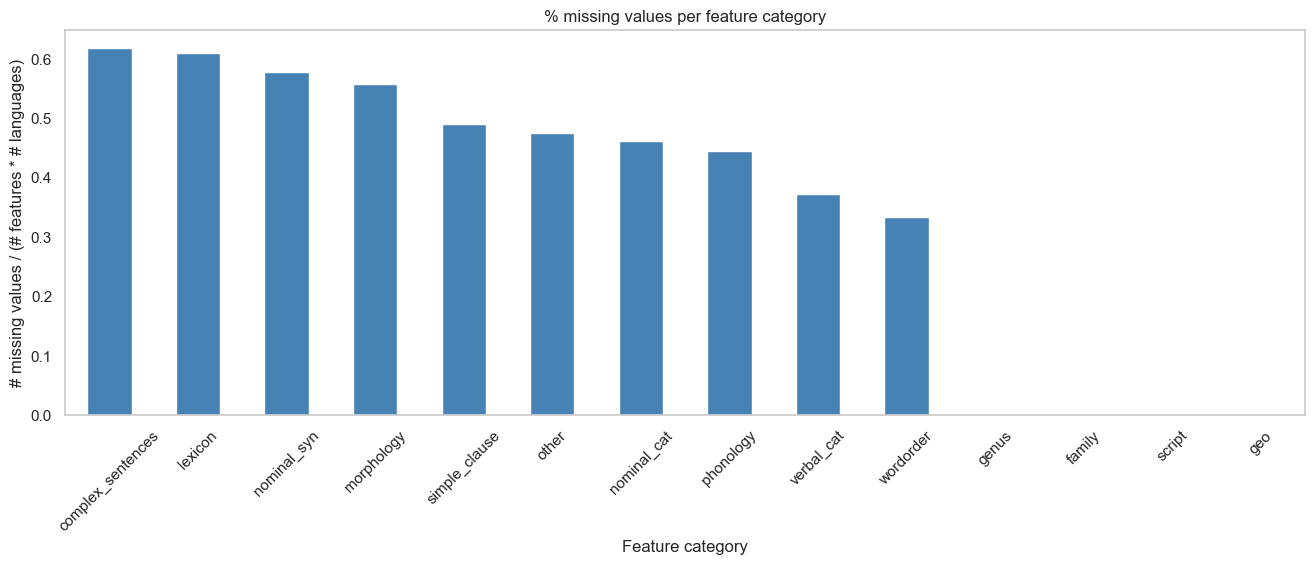

In [30]:
missing_values_category = pd.DataFrame()

missing_values_category['genus'] = walsdata_test[genus].isnull().sum(axis=1) / (len(genus) * len(walsdata_test))
missing_values_category['family'] = walsdata_test[family].isnull().sum(axis=1) / (len(family) * len(walsdata_test))
missing_values_category['script'] = walsdata_test[script].isnull().sum(axis=1) / (len(script) * len(walsdata_test))
missing_values_category['geo'] = walsdata_test[geo].isnull().sum(axis=1) / (len(geo) * len(walsdata_test))
missing_values_category['phonology'] = walsdata_test[phonology].isnull().sum(axis=1) / (len(phonology) * len(walsdata_test))
missing_values_category['morphology'] = walsdata_test[morphology].isnull().sum(axis=1) / (len(morphology) * len(walsdata_test))
missing_values_category['nominal_cat'] = walsdata_test[nominal_cat].isnull().sum(axis=1) / (len(nominal_cat) * len(walsdata_test))
missing_values_category['nominal_syn'] = walsdata_test[nominal_syn].isnull().sum(axis=1) / (len(nominal_syn) * len(walsdata_test))
missing_values_category['verbal_cat'] = walsdata_test[verbal_cat].isnull().sum(axis=1) / (len(verbal_cat) * len(walsdata_test))
missing_values_category['wordorder'] = walsdata_test[wordorder].isnull().sum(axis=1) / (len(wordorder) * len(walsdata_test))
missing_values_category['simple_clause'] = walsdata_test[simple_clause].isnull().sum(axis=1) / (len(simple_clause) * len(walsdata_test))
missing_values_category['complex_sentences'] = walsdata_test[complex_sentences].isnull().sum(axis=1) / (len(complex_sentences) * len(walsdata_test))
missing_values_category['lexicon'] = walsdata_test[lexicon].isnull().sum(axis=1) / (len(lexicon) * len(walsdata_test))
missing_values_category['other'] = walsdata_test[other].isnull().sum(axis=1) / (len(other) * len(walsdata_test))

column_sums = missing_values_category.sum(axis=0)
column_sums = column_sums.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(16, 5))
column_sums.plot(kind='bar',color='steelblue',ax=ax)

plt.title('% missing values per feature category')
plt.grid(False)
plt.xlabel('Feature category')
plt.ylabel('# missing values / (# features * # languages)')
plt.xticks(rotation=45) 
plt.show()

Earth map of all languages in the set grouped by family, genus and script.

C:\Users\maras\AppData\Local\Temp\ipykernel_17452\745403828.py:7: UserWarning: The palette list has more values (26) than needed (15), which may not be intended.
  sns.scatterplot(x='longitude', y='latitude', hue='family', data =walsdata_test, legend=True, palette=palette)


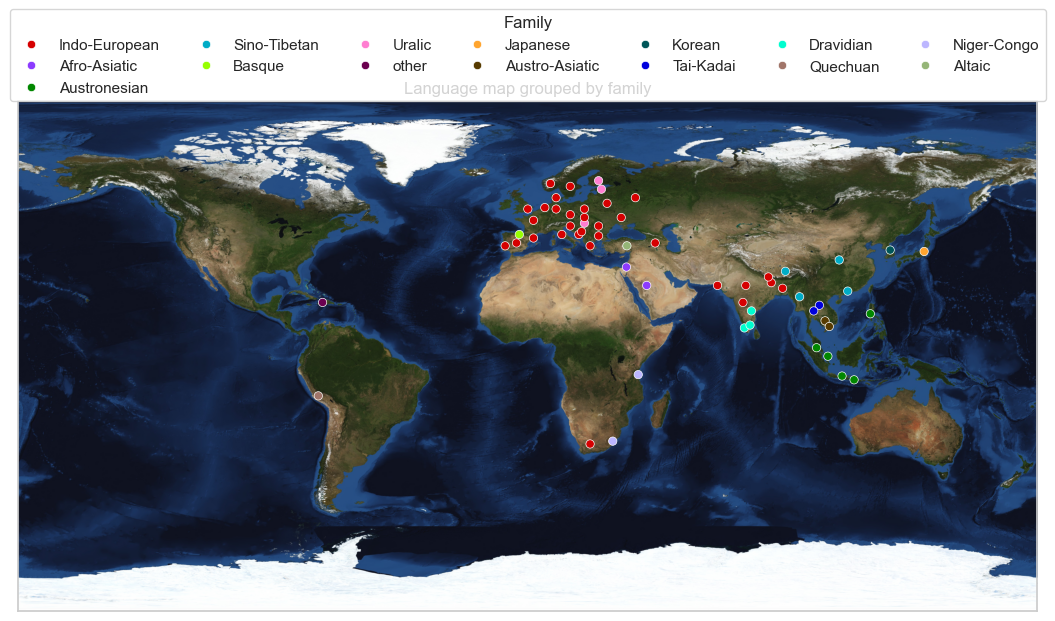

C:\Users\maras\AppData\Local\Temp\ipykernel_17452\745403828.py:18: UserWarning: 
The palette list has fewer values (26) than needed (27) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='longitude', y='latitude', hue='genus', data =walsdata_test, legend=True, palette=palette)


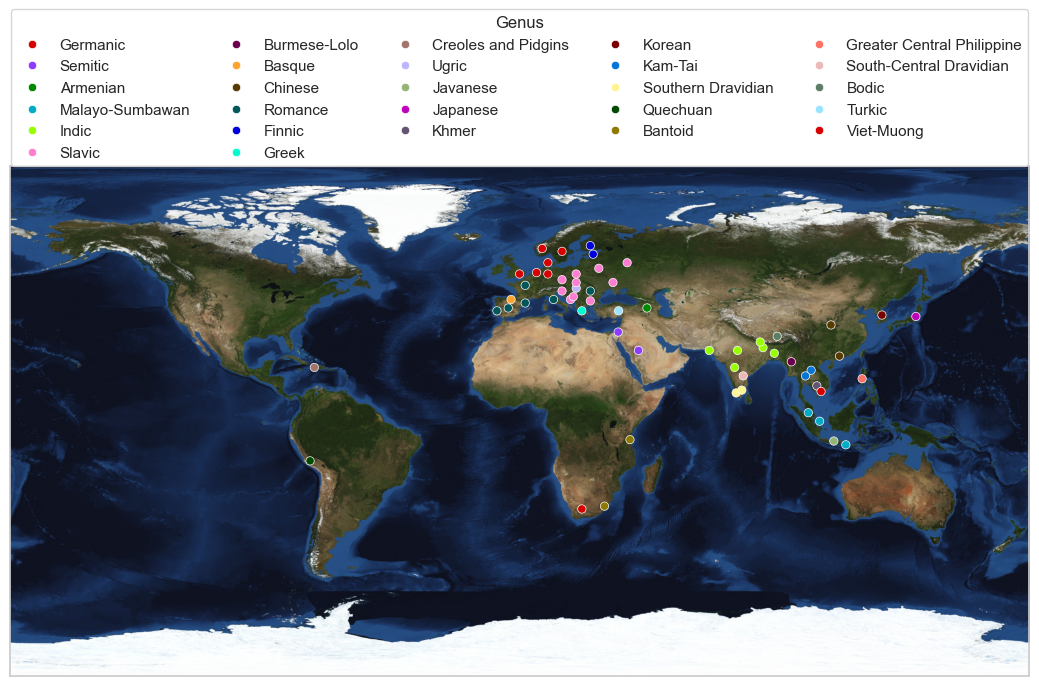

C:\Users\maras\AppData\Local\Temp\ipykernel_17452\745403828.py:28: UserWarning: The palette list has more values (26) than needed (19), which may not be intended.
  sns.scatterplot(x='longitude', y='latitude', hue='Script', data =walsdata_test, legend=True, palette=palette)


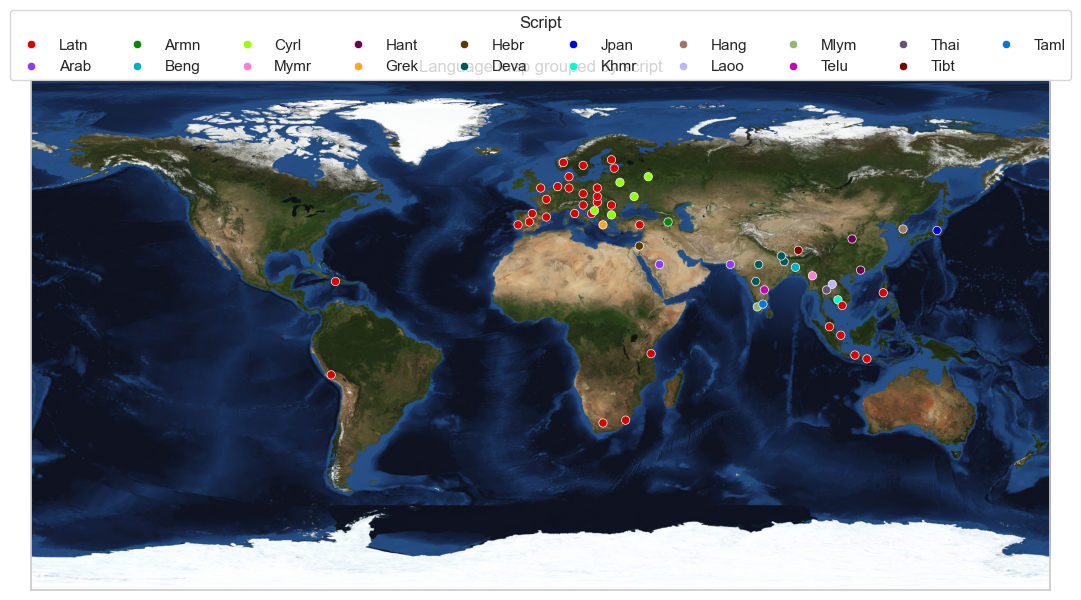

In [13]:
earth = Basemap()

plt.figure(figsize=(13.15,12))
earth.bluemarble(alpha=0.95)

palette = sns.color_palette(cc.glasbey, n_colors=26)
sns.scatterplot(x='longitude', y='latitude', hue='family', data =walsdata_test, legend=True, palette=palette)

plt.title("Language map grouped by family")
plt.legend(title='Family', bbox_to_anchor=(0.5, 1), loc='lower center', ncol=7, borderaxespad=0.)
plt.show()


plt.figure(figsize=(13.15,12))
earth.bluemarble(alpha=0.95)

palette = sns.color_palette(cc.glasbey, n_colors=26)
sns.scatterplot(x='longitude', y='latitude', hue='genus', data =walsdata_test, legend=True, palette=palette)

# plt.title("Language map grouped by genus")
plt.legend(title='Genus', bbox_to_anchor=(0.5, 1), loc='lower center', ncol=5, borderaxespad=0.)
plt.show()

plt.figure(figsize=(13.15,12))
earth.bluemarble(alpha=0.95)

palette = sns.color_palette(cc.glasbey, n_colors=26)
sns.scatterplot(x='longitude', y='latitude', hue='Script', data =walsdata_test, legend=True, palette=palette)

plt.title("Language map grouped by script")
plt.legend(title='Script', bbox_to_anchor=(0.5, 1), loc='lower center', ncol=10, borderaxespad=0.)
plt.show()

Countplots for each feature column can be visualized here. Since there are too many features to show, we present here only the phonology features as example.

In [46]:
def countplot(column):
    fig, ax = plt.subplots(figsize=(6, 2))
    sns.countplot(y=column, data=walsdata_test, order=walsdata_test[column].value_counts().index, ax=ax, color='skyblue')
    ax.set_xlabel("Count")
    ax.set_ylabel("")
    ax.set_title(column)

    plt.tight_layout()
    plt.show()

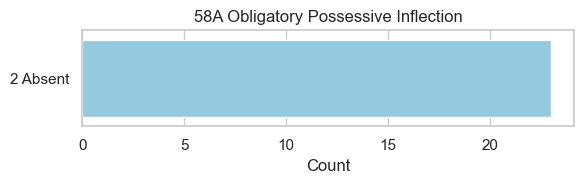

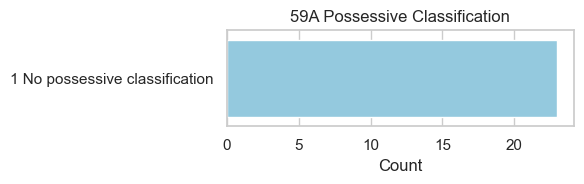

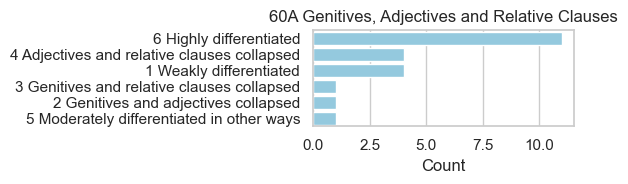

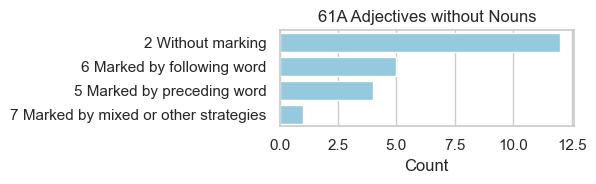

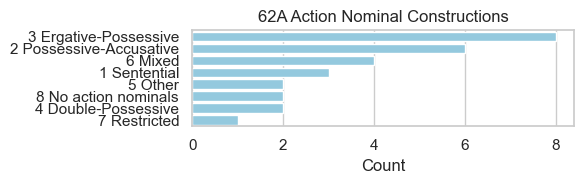

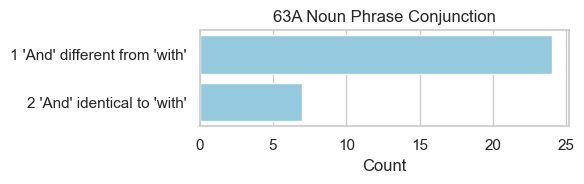

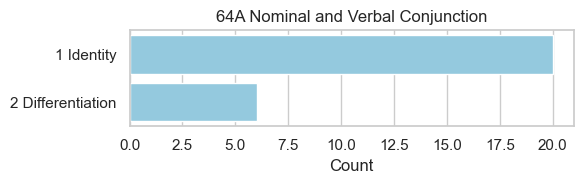

In [47]:
for column in walsdata_test[nominal_syn].columns:
    countplot(column)

### References

1. Cobbe, K., Kosaraju, V., Bavarian, M., Chen, M., Jun, H., Kaiser, L., ... & Schulman, J. (2021). Training verifiers to solve math word problems. arXiv preprint arXiv:2110.14168.
2. Shi, F., Suzgun, M., Freitag, M., Wang, X., Srivats, S., Vosoughi, S., ... & Wei, J. (2022). Language models are multilingual chain-of-thought reasoners. arXiv preprint arXiv:2210.03057.
3. Qin, L., Chen, Q., Wei, F., Huang, S., & Che, W. (2023). Cross-lingual prompting: Improving zero-shot chain-of-thought reasoning across languages. arXiv preprint arXiv:2310.14799.
4. Huang, H., Tang, T., Zhang, D., Zhao, W. X., Song, T., Xia, Y., & Wei, F. (2023). Not All Languages Are Created Equal in LLMs: Improving Multilingual Capability by Cross-Lingual-Thought Prompting. arXiv preprint arXiv:2305.07004.
5. Ponti, E. M., Glavaš, G., Majewska, O., Liu, Q., Vulić, I., & Korhonen, A. (2020). XCOPA: A multilingual dataset for causal commonsense reasoning. arXiv preprint arXiv:2005.00333.
6. Roemmele, M., Bejan, C. A., & Gordon, A. S. (2011, March). Choice of plausible alternatives: An evaluation of commonsense causal reasoning. In 2011 AAAI Spring Symposium Series.
7. Dryer, Matthew S. & Haspelmath, Martin (eds.) 2013. WALS Online (v2020.3) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.7385533 (Available online at https://wals.info, Accessed on 2024-01-30.)
8. Unicode CLDR (2023). Languages and scripts. Retrieved from https://www.unicode.org/cldr/charts/44/supplemental/languages_and_scripts.html
9. Costa-jussà, M. R., Cross, J., Çelebi, O., Elbayad, M., Heafield, K., Heffernan, K., ... & NLLB Team. (2022). No language left behind: Scaling human-centered machine translation. arXiv preprint arXiv:2207.04672.
10. Touvron, H., Martin, L., Stone, K., Albert, P., Almahairi, A., Babaei, Y., ... & Scialom, T. (2023). Llama 2: Open foundation and fine-tuned chat models. arXiv preprint arXiv:2307.09288.
11. Muennighoff, N., Wang, T., Sutawika, L., Roberts, A., Biderman, S., Le Scao, T., ... & Raffel, C. Crosslingual Generalization through Multitask Finetuning, 2022. URL https://arxiv. org/abs/2211.01786.
12. Georgi, R., Xia, F., & Lewis, W. (2010, August). Comparing language similarity across genetic and typologically-based groupings. In Proceedings of the 23rd international conference on computational linguistics (Coling 2010) (pp. 385-393).